# Νευρωνικά Δίκτυα 2021-2022
## 2η Εργαστηριακή Άσκηση:  Μη επιβλεπόμενη μάθηση.
* Σύστημα συστάσεων βασισμένο στο περιεχόμενο
* Σημασιολογική απεικόνιση δεδομένων με χρήση SOM

## Στοιχεία Ομάδας:


*   Αριθμός 90
*   Σαραντινόπουλος Ευστάθιος Αλέξανδρος -- 031 16801
*   Κωστόπουλος Κωνσταντίνος -- 031 17043
*   Τσαούσης Κωνσταντίνος -- 031 17652




## Installations & Imports

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install -U gensim

In [2]:
import pandas as pd, numpy as np, scipy as sp
import nltk, string, collections
import time, joblib
import itertools


from IPython.display import display
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.decomposition import PCA

import gensim.downloader
from gensim.models.word2vec import Word2Vec

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Εισαγωγή του Dataset

In [4]:
dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

Κάθε ομάδα θα δουλέψει σε ένα μοναδικό υποσύνολο 5.000 ταινιών (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε
τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame df_data_2 έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το team_seed_number της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset.

Στην περίπτωσή μας, αν και *η ομάδα μας στο helios είναι η 90,* κατά την διάρκεια της εργασίας εμφανίστηκε πρόβλημα με το συγκεκριμένο seed οπότε *κατόπιν συννενόησης με τον κ. Σιόλα* **χρησιμοποιούμε σαν seed to 136**


In [5]:
team_seed_number = 136 #          το 90 εμφάνιζε πρόβλημα οπότε μετά απο συννενόηση με τον κ. Σιόλα χρησιμοποιήσαμε το 136.

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header=None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number,:].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus


* Ο πίνακας titles περιέχει τους τίτλους των ταινιών. Παράδειγμα: ‘Sid and Nancy’.
* O πίνακας categories περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: ‘“Tragedy”, “Indie”, “Punk rock”, “Addiction Drama”, “Cult”, “Musical”, “Drama”, “Biopic [feature]”, “Romantic drama”, “Romance Film”, “Biographical film”’. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
* Ο πίνακας catbins περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή (one hot encoding). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
* Ο πίνακας summaries και η λίστα corpus περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: ‘The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.’
* Το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως ID της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με ID=999 (την χιλιοστή) θα γράψουμε print(corpus[999]).

In [94]:
ID = 999

print(my_index[ID])

print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])


11615
['Big Daddy']
['"Thriller",  "Drama",  "Adventure"']
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξουμε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). 

Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. 

Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η
επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξουμε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


### 1. Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Αφού τυπώσαμε αρκετές περιγραφές των ταινιων παρατηρήσαμε αρκετές λέξεις οι οποίες δεν έχουν ουσία στην κατηγοριοποίηση όπως άρθρα (he, she etc), σημεία στίξης, ονόματα, σχέσεις συγγένειας (mother, father, son), αριθμοί καθώς και "κινηματογραφικές λέξεις" όπως plot, film κλπ.

Θα χρησιμοποιησουμε λοιπόν κάποες βιβλιοθήκες για stopwords (punkt, gensim κα), θα προσθεσουμε τι δικές μας και θα αφαιρέσουμε σημεία στίξης κλπ.



In [7]:
import gensim, spacy, re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [8]:
nltk_stopwords = stopwords.words('english')
spacy_stopwords = list(spacy.load('en_core_web_sm').Defaults.stop_words)
gensim_stopwords = list(gensim.parsing.preprocessing.STOPWORDS)

print(nltk_stopwords)
print(spacy_stopwords)
print(gensim_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Αφού έχουμε τις λίστες με τα stopwords, προσθέτουμε τις επιπλέον δικές μας, τις ενώνουμε, αφαιρούμε τις κοινές, και κρατάμε κάποιες που κρίνουμε οτι είναι σημαντικές και δεν θα έπρεπε να αφεραιθούυν.

In [9]:
extra_words = ['dvd','cinema','story','film','plot','summary','synopsis','about','movie','main','character','leading','role','starring','000','mother','father','sister','brother','daughter','son', "boy", "girl",'village'
             '10', '12', '15', '20','0','1','2','3','4','5','6','7','8','9','00','01', '02', '04', '05', '06', '07', '08', '09', '100', '1000', '10th', '11', 
             '120', '13', '13th', '14', '14th', '150', '15th', '16', '16th', '17', '18', 'depicts', 'rest', 'revolves', 'around','test', 'published', 'filmed']
stop_words1 = nltk_stopwords + spacy_stopwords + gensim_stopwords + extra_words   
stop_words1 = list(dict.fromkeys(stop_words1))                         

keep_words = ["fire","cry","computer","system","move"]               
stop_words1 = [word for word in stop_words1 if word not in keep_words]
print(stop_words1)
print("Total number of stopwords is ", len(stop_words1))
#print("Total number of stopwords is \033[1m{}\033[0m".format(len(stop_words)))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Στην συνέχεια προσθέτουμε στα ήδη υπάρχοντα stopwords μας, χιλιάδες ανδρικά και γυναικεία ονόματα από το αρχείο names.txt

In [10]:
#name_file = open("names.txt",'r')
name_file = open('/content/drive/MyDrive/neural/lab2/names.txt','r')
names = [line.split(',') for line in name_file.readlines()]
name_stopwords = names[0]

for i in range(len(name_stopwords)): name_stopwords[i]=name_stopwords[i].strip()

#print("Total number of names is \033[1m{}\033[0m".format(len(name_stopwords)))

final_stopwords = stop_words1 + name_stopwords
print(final_stopwords)
print("Total number of stopwords is {}".format(len(final_stopwords)))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Τέλος πάμε να ολοκληρώσουμε την προεπεξεργασία τους corpus. 
θα δημιουργήσουμε την συνάρτηση thorough filter για την αφαίρεση των σημείων στίξης καθώς και την preprocess_document ώστε να εκτελέσουμε τα παρακάτω βήματα:
1. Αφαίρεση των λινκς
2. Μετατροπή των κεφαλαίων χαρακτήρων σε πεζούς
3. Αφαίρεση των σημείων στίξης και των προαναφερθέντων stopwords
4. Lemmatization


In [96]:
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
          pun.append(letter in string.punctuation)
        if not all(pun):
          filtered_words.append(word)
    return filtered_words

def preprocess_document(document):
  
    # Διαγραφή υπερσυνδέσμων (URLs)
    document = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', document)

    words = nltk.word_tokenize(document.lower())     # Μετατροπή κεφαλαίων γραμμάτων σε πεζά
  
    filtered_words = [word for word in words if word not in (final_stopwords) + list(string.punctuation)]   # Διαγραφή stopwords και σημείων στίξης
    
    filtered_words = thorough_filter(filtered_words)     # Επιπλέον φιλτράρισμα σημείων στίξης 

    words = [WordNetLemmatizer().lemmatize(word) for word in filtered_words]      # Λημματοποίηση

    return " ".join(words)

In [12]:
#test prints
print(corpus[ID])
print(preprocess_document(corpus[ID]))

A man  visiting the Florida Everglades falls for an illiterate girl, and competes with the mysterious A. Lincoln Beauregard  for her affections. He also encounters vicious alligators and a voodoo witch doctor.Jim Beaver Plot SummaryTCM Full synopsis
visiting everglades fall illiterate competes mysterious a. beauregard affection encounter vicious alligator voodoo witch doctor.jim beaver summarytcm


#### 1.1 Preprocessed corpus

In [98]:
#skip this, we can load corpus
preprocessed_corpus = [preprocess_document(doc) for doc in corpus]


### 2. Αρχική μετατροή σε TFIDF

Για αρχή μετατρέοπουμε το corpus σε αναπαράσταση tf-idf χωρίς κάποια περαιτέρω βελτιστοποίηση

In [99]:
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_0 = vectorizer.transform(preprocessed_corpus).toarray()

In [100]:
print(corpus_tf_idf_0.shape)

(5000, 41945)


### 3. Υλοποίηση recommender system

Το σύστημα συστάσεων που θα υλοποιήσουμε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.

Θα υλοποιήσουμε την συνάρτηση ως εξής:
- για την ταινία-στόχο, θα υπολογίσουμε την ομοιότητα συνημιτόνου της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσαμε, θα δημιουργήσουμε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο θα εκτυπώσουμε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [101]:
def content_recommender(target_movie,max_recommendations,corpus_type):

    distances = np.zeros(len(corpus_type))            # Αρχικοποίηση πίνακα για τις αποστάσεις συνημιτόνου μεταξύ των περιγραφών ταινιών

    for i in range(corpus_type.shape[0]):             # Διατρέχουμε το σύνολο όλων των ταινιών
        if not np.any(corpus_type[i]):                # Αν κάποιο διάνυσμα tf-idf είναι μηδενικό τότε τότε θέτουμε απλά distance = 1 έτσι ώστε να μην λάβουμε NaN value στο distance                                          
            distances[i] = 1.0                             
        else:                                           # Υπολογισμός απόστασης συνημιτόνου μεταξύ της target movie και της εκάστοτε ταινίας    
            distances[i] = sp.spatial.distance.cosine(corpus_type[target_movie],corpus_type[i])   
                                                                                                
    movie_IDs = distances.argsort()[:(max_recommendations+1)]      # Εντοπισμός των IDs των ταινιών με τη μικρότερη απόσταση από την target movie (max_recommendations όμοιες ταινίες)
    ID = movie_IDs[0]                                              # ID της target_movie (distance = 0 με τον ευατό της)
    recommendations = movie_IDs[1:]                                # Αφαίρεση της ταινία-στόχου από τις προτεινόμενες ταινίες

    my_movie = [[ID, titles[ID][0],corpus[ID],categories[ID][0]]]  # Δημιουργία DataFrame για απεικόνιση του ID, του τίτλου, της σύνοψης και των κατηγοριών της ταινίας στόχου
      
    target_movie_df = pd.DataFrame(my_movie, columns = ['ID', 'Title', 'Summary', 'Categories']) 
    target_movie_df = target_movie_df.style.set_properties(**{'text-align': 'center'})
    pd.set_option('display.max_columns', None)  

    print("\033[1m------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------\033[0m\n\n")
    display(target_movie_df.hide_index())
    print("\n\n")

    # Δημιουργία DataFrames για απεικόνιση του ID, του τίτλου, της σύνοψης και των κατηγοριών όλων των max_recommendations ταινιών

    for i,id in enumerate(recommendations):

        data = [[id, titles[id][0],corpus[id],categories[id][0]]]
        df = pd.DataFrame(data, columns = ['ID', 'Title', 'Summary', 'Categories']) 
        df = df.style.set_properties(**{'text-align': 'center'})
        pd.set_option('display.max_columns', None)  
        print("\033[1m--------------------------------------------------------------------------------- RECOMMENDED MOVIE {} ---------------------------------------------------------------------------------\n\n".format(i+1))
        display(df.hide_index())
        print("\n\n")

### 4. Εύρεση παραμέτρων βελτιστοποίησης του TfidfVectorizer

Στο σημείο αυτό, και αφού έχουμε υλοποιήσει την reccommender συνάρτησή μας θα προχωρήσουμε στο να βρούμε πειραματικά τις παραμέτρους βελτιστοποίησης της TfidfVectorizer. Θα πάρουμε μερικά reccomendations τώρα στα οποία θα σημειώσουμε το ID και τις προτάσεις που θα λάβουμε και θα τα συγκρίνουμε τα τις προτάσεις μετά την βελτιστοποίηση.

#### Παράδειγμα 1

In [108]:
id = 4888
maxrecs = 3
print(preprocess_document(corpus[id]))
content_recommender(target_movie=id,max_recommendations=maxrecs,corpus_type=corpus_tf_idf_0)

certain order inherit working uncle mysterious villain mystic mendicant
------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------




Παρατηρούμε 2 πολύ κακά reccomendations στα movies 2 και 3 τα οποίαδεν σχετίζονται με την πλοκή της ταινίας

#### Παράδειγμα 2

In [127]:
id = 4482
maxrecs = 3
print(preprocess_document(corpus[id]))
content_recommender(target_movie=id,max_recommendations=maxrecs,corpus_type=corpus_tf_idf_0)

kung-fu master killed student wife forced suicide life eventually lao discovers hermit history shaolin drunken kung-fu taught kung-fu avenge parent lao kidnaps men betrayed luring process defeating minion lao befriends one-handed fighter similar revenge fall lao lao one-handed team-up final battle death fight commits suicide grievance past deed death lao
------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------




Εδώ έχουμε μια ξεκάθαρη martial arts ταινία ωστόσο δεν είναι όλα τα recommendations σχετικά με πολεμικές τέχνες ή chinese movies.

#### Παράδειγμα 3

In [134]:
id = 556
maxrecs = 3
print(preprocess_document(corpus[id]))
content_recommender(target_movie=id,max_recommendations=maxrecs,corpus_type=corpus_tf_idf_0)

set 1958 coming-of-age follows brooklyn teenager known lord flatbush lord girl steal car play pool local malt shop focus chico attempting win want little impregnates girlfriend frannie want
------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------




Εδώ βλέπουμε μια coming of age ταινία η οποία επειδή έχει την λέξη Lords στον τίτλο της, ο recommender μας προτείνει epic ταινίες με Λόρδους.

### 5. Βελτιστοποίηση του TfidfVectorizer

Παρακάτω κάνουμε δοκιμές και φτιάχνουμε corpus με διαφορετικές παραμέτρους στο TfidfVectorizer. 

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.2, min_df=20,stop_words=final_stopwords,ngram_range=(1,2))
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_1 = vectorizer.transform(preprocessed_corpus).toarray() #could change that
print("Corpus 1 Dimensions", corpus_tf_idf_1.shape)

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.1, min_df=25,stop_words=final_stopwords,ngram_range=(1,1))
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_2 = vectorizer.transform(preprocessed_corpus).toarray() #could change that
print("Corpus 2 Dimensions", corpus_tf_idf_2.shape)

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=13,stop_words=final_stopwords,ngram_range=(1,2))
vectorizer.fit(preprocessed_corpus)
corpus_tf_idf_3 = vectorizer.transform(preprocessed_corpus).toarray() #could change that
print("Corpus 3 Dimensions", corpus_tf_idf_3.shape)

Corpus 3 Dimensions (5000, 6096)


Καταλήγουμε στο Corpus 3. Τους λόγους επιλογής του εξηγούμε στην ενότητα 7.

#### 5.1 Αποθήκευση Corpus μέσω joblib

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. 

Συγκεκριμένα μπορούμε να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε

In [ ]:
# αποποθήκευση corpus
joblib.dump(corpus_tf_idf_3, 'corpus_tf_idf_3.pkl')

['corpus_tf_idf_3.pkl']

In [ ]:
# φόρτωση corpus
corpus_tf_idf_3 = joblib.load('corpus_tf_idf_3.pkl')

### 6. Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

H προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
number_model = gensim.downloader.load("conceptnet-numberbatch-17-06-300")

[==================================================] 100.0% 1168.7/1168.7MB downloaded


In [ ]:
joblib.dump(number_model, 'number_model.pkl')

['number_model.pkl']

#### 6.1 DeepL Corpus

In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):
  final=[]
  for i in range(len(corpus)):
    print(i)
    sentence=corpus[i]
    tf_idf_array=[]
    products_all=0
    final_val = 0
    for word in sentence:
      if word in vectors.index_to_key: 
        index = corpus_tf_idf_3.vocabulary_[word]
        tf_idf_val = vectorizer[i][index]
        tf_idf_array.append(tf_idf_val)
        emb_val = vectors[word][:embeddings_size]
        product = tf_idf_val * emb_val
        products_all += product

    if sum(tf_idf_array) != 0:
      final_val = products_all/(sum(tf_idf_array))

    final.append(final_val)
  return final

In [ ]:
updated_corpus = build_tfw2v(preprocessed_corpus, number_model, 300)

Το παραπάνω code block βγάζει αποτελέσματα ελάχιστα αποδοτικότερα από αυτά του TfidfVectorizer και, δεδομένου ότι έχει τεράστιο χρόνο εκτέλεσης, το απορρίπτουμε.

#### 6.2 DeepL Corpus (Revised)

Αν πάρουμε ένα gensim dataset και το εκπαιδεύσουμε με το δικό μας λεξιλόγιο, παρατηρούμε ότι το νέο, ανανεωμένο λεξιλόγιο λειτουργεί εξίσου καλά με την μέθοδο που ακολουθήθηκε στο προηγούμενο section. Αυτό είναι λογικό, καθώς το μόνο που αλλάζει ουσιαστικά είναι ο χρόνος εκτέλεσης. Συγκεκριμένα, η build_tfw2v() τρέχει 5000 φορές (len(corpus)) * τον αριθμό των λέξεων σε κάθε πρόταση, ενώ στην build_tfw2v_rev() η μόνη χρονοβόρα διαδικασία είναι αυτή της εκπαίδευσης. Εννοείται ότι η παρακάτω προσέγγιση δεν αποτελεί βέλτιστη λύση, για πληθώρα εμφανών λόγων.

In [ ]:
newcorpus = gensim.downloader.load("text8")

In [ ]:
def build_tfw2v_rev(corpus, vectors, embeddings_size):
  vectors.train(corpus, total_examples=4, epochs=1)
  return vectors.wv

In [ ]:
model = Word2Vec(sentences=newcorpus, vector_size=100, window=5, min_count=1, workers=4)
sela_corpus = build_tfw2v_rev(preprocessed_corpus, model, 300)

In [ ]:
sela_corpus.most_similar("leningrad")

Δυστυχώς αντιμετωπίσαμε προβλήματα με το world2vec μοντέλο οπότε προχωρήσαμε με το tfidf

### 7. Αποτελέσματα

Μετά από τις διάφορες δοκιμές μας καταλήγουμε στο `corpus_tf_idf_3` καθώς είχε ενα καλό μέγεθος ενώ παράλληλα μας έδινε τα καλύτερα reccomendations από τα υπόλοιπα.

Σχετικά με τις παραμέτρους που επιλέξαμε έχουμε τα εξής:

* Επιλέξαμε να θέσουμε **max_df = 0,5**. Οι διάφορες τιμές του max_df επηρρέαζαν το μέγεθος σε πολύ μικρό βαθμό. Με την επιλογή του 0,5 αφαιρούμε τις λέξεις που εμφανίζονται σε ποσοστό μεγαλύτερο από το 50% των ταινιών. Οι περισσότερες έχουν ήδη κοπεί ωστόσο με αυτόν τον περιορισμό αφαιρούμε και κάποιες λέξεις που θα ξέφυγαν από τα stopwords χωρίς ωστόσο να κάνουμε ζημιά στην ποιότητα των reccomendations.

* Επιλέξαμε να θέσουμε **min_df = 13**. Με αυτήν την τιμή κόβουμε τις λέξεις που εμφανίζονται σε λιγότερα απο 13 summaries ταινιών. Η παράμετρος min_df άλλαζε θεαματικά το corpus μας. Βάζοντας 13 μεγαλώσαμε το μέγεθος του corpus ωστόσο κρατήσαμε την ποιότητα των reccomendations υψηλή. 

* Σχετικά με τα ngrams, θέσαμε **ngram_range = (1,2)**. Επιλέξαμε δηλαδή να κρατήσουμε monograms (n = 1) και bigrams(n = 2). Παρότι η διαφορά απο ένα σε δύο ανεβάζει σημαντικά το μέγεθος, από τις δοκιμές μας κρίναμε ότι κάποια bigrams επηρρεάζουν σημαντικά τις προτάσεις. Λέξεις όπως secret, final, commit, seek έχουν εντελώς διαφορετική σημασία όταν στέκονται μόνες τους και διαφορετική όταν σε κάποιο ζευγάρι π.χ. secret society, final performance, commit suicide, seek revenge. Για τον λόγο αυτό συμπεριλάβαμε και και τα bigrams αγνοόντας τα trigrams τα οποία συμπεριλαμβάνονται σε έναν βαθμό και τα bigrams. 

Σχετικά με τον tfidf recommender μας έχουμε τα εξής:

#### 5 Nit-Picking παραδείγματα

Ακολουθούν 5 "κακά" αποτελέσματα και η εξήγηση για καθένα απο αυτά.

In [14]:
# φόρτωση corpus
corpus_tf_idf_3 = joblib.load('/content/drive/MyDrive/neural/lab2/corpus/corpus_tf_idf_3.pkl')

##### Nit-pick #1

H ταινία έχει να κάνει με εναν άντρα που πρέπει να παντρευτεί ώστε να καταφέρει κάτι. Συγκεκριμένα να κληρονομήσει τους New York Times. Ενώ έχουμε κάποια καλά αποτελέσματα με ανθρώπους που πρέπει να παντρευτούν η να κληρονομήσουν κάτι, έχουμε πολλές προτάσεις οι οποίες είναι άσχετες αλλά έχουν στο summary τους Ney York Times. Αυτό μπορεί να ρυθμιστεί με καλύτερα stopwords σχετικά με την εφημερίδα.

In [112]:
content_recommender(target_movie = 4888, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Nit-Pick #2
H ταινία είναι ένα άνιμε με κάποιους δυνατούς πολλέμιστές που φτιάχνουν μια ομάδα για να σταματήσυν έναν τύρρανο. Ενώ έχουμε κάποιες προτάσεις με επικές ταινίες και ομάδες που πρέπει να σώσουν τον κόσμο έχουμε πολλά recommendations με sports ταινίες λόγω των keywords: powerful, team, captain, strong που εμφανίζονται πολλές φορές στο summary.

In [113]:
content_recommender(target_movie = 2312, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Nit-Pick #3
Η ταινία είναι μια coming of age ταινία με κάτι παιδιά στην Αμερική του 60'. Ωστόσο, επειδή έχει την λέξη Lords στον τίτλο ο recommender εκτός απο άλλες coming of age μας προτείνει αρκετές epic, historic ή period piece ταινίες οι οποίες έχουν να κάνουν με Λόρδους.



In [135]:
content_recommender(target_movie = 556, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Nit-Pick #4
H ταινία είναι μια Bollywood περιπέτεια. Ωστόσο επειδή περιέχει το όνομα Raja μας βγάζει διάφορες Bollywood και μη ταινίες οι οποίες δεν συνδέονται νοηματικά παρα μόνο απο το Raja

In [131]:
content_recommender(target_movie = 1996, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Nit-Pick #5
Eδώ έχουμε λενα musical, comedy για το οποίο ο recommender μας προτείνει ασύνδετες ταινίες. Υπάρχει μικρή σχέση με τις προτάσεις οι λέξεις ranch και manager στο plot αλλά κατα τα άλλη πολύ μικρή νοηματική συνέχεια. Ωστόσο είναι πολύ πιθανό να μην φταίει απαραίτητα ο recommender αλλά το πολύ μικρό summary.

In [136]:
content_recommender(target_movie = 3643, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




#### 5 Cherry-Picking παραδείγματα

Ακολουθούν 5 cherry-picked ταινίες και η εξηγησή τους

##### Cherry-Pick #1 
Εδώ έχουμε μια Δραματική ταινία, με μια παρέα Ρομά, σχεδόν όλα τα reccomendations είναι αντίστοιχα ως προς την κατηγορία και το έθνικ κομμάτι.

In [121]:
content_recommender(target_movie = 2222, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Cherry-Pick #2
Μια ξεκάθαρη martial arts / chinese movie όπου και όλα τα reccomendations ανήκουν στην κατηγορία

In [129]:
content_recommender(target_movie = 4482, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Cherry-Pick #3
Όλες οι ταινίες σχετικές με τον Ροζ Πάνθηρα και στην ίδια κατηγορία, short film, comedy, animation

In [130]:
content_recommender(target_movie = 3725, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Cherry-Pick #4
Εδώ έχοουμε διάφορα musicals, και comedies τα οποία σχετίζονται με χορωδίες καθώς και ενα ελαφρύ θρησκευτικό στοιχείο

In [137]:
content_recommender(target_movie = 2612, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




##### Cherry-Pick #5
Εδώ έχουμε να κάνουομε με thriller-horror zombie films όπου όλες οι ταινίες είναι σχετικές

In [138]:
content_recommender(target_movie = 606, max_recommendations=8, corpus_type=corpus_tf_idf_3)

------------------------------------------------------------------------------------- TARGET MOVIE -------------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 1 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 2 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 3 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 4 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 5 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 6 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 7 ---------------------------------------------------------------------------------







--------------------------------------------------------------------------------- RECOMMENDED MOVIE 8 ---------------------------------------------------------------------------------




### 8. Συμπεράσματα

Συμπερασματικά, διαπιστώνουμε πως το **βελτιστοποιημένο** σύστημα προτάσεων έχει εξαιρετική απόδοση, αφού για ένα αρκετά μεγάλο αριθμό συστάσεων (**`max_recommendations=8`**) και για ένα σύνολο 8 ταινιών που ανήκουν σε διαφορετικά είδη, επιστρέφει πολύ καλά αποτελέσματα. Φαίνεται λοιπόν, πως η μείωση της διαστατικότητας του Vector Space Model ήταν αρκετά επιτυχημένη καθώς εξαλείφθηκαν ανεπιθύμητες ομοιότητες μεταξύ των κειμένων και δώθηκε έμφαση σε λέξεις που προσδίδουν σημαντική σημασία στο σημασιολογικό περιεχόμενο των περιγραφών.

## Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

### 1. Δημιουργία dataset

Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 


Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα δώσουμε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορούμε αν θέλουμε να φτιάξουμε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [18]:
print(corpus_tf_idf_3)
corpus_tf_idf_3.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(5000, 6110)

In [19]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit,:]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    # η somoclu θέλει δεδομ΄ένα σε float32
    return np.array(final_set, dtype=np.float32)

In [ ]:
final_set = build_final_set(corpus_tf_idf_3)
final_set.shape

(5000, 6432)

#### 1.1 Βελτιστοποίηση PCA

Επειδή οι διαστάσεις μας είναι αρκετές, θα χρησιμοποιήσουμε PCA ωστε να τις μικρύνουμε για ευκολία στην διαχείρηση χωρίς μεγάλο κόστος.

In [20]:
# φόρτωση FINAL SET
final_set_opt = joblib.load('/content/drive/MyDrive/neural/lab2/soms/final_set_opt.pkl')

In [ ]:
pca = PCA(n_components=0.962)
final_set_opt = pca.fit_transform(final_set)
print(final_set_opt.shape)
print("Decrease of components:", round ((1-final_set_opt.shape[1]/final_set.shape[1])*100, 2 ),"%")

(5000, 1998)
Decrease of components: 68.94 %


In [ ]:
# αποποθήκευση final set
joblib.dump(final_set_opt, 'final_set_opt.pkl')

['final_set_opt.pkl']

### 2. Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

#### 2.1 Installations & Imports

In [21]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

     |████████████████████████████████| 6.1 MB 24.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for somoclu: filename=somoclu-1.7.5.1-cp37-cp37m-linux_x86_64.whl size=481114 sha256=8ed9a0cd94f77808f056668cdc0ffc705c7110b95ee0403c5c9b4cbb2e15094b
  Stored in directory: /root/.cache/pip/wheels/d5/81/eb/22b023e9cac575c4b87d3f9a7318094124e5d8cf90600726fa
Successfully built somoclu


#### 2.2 Training Preparation & Optimization

Καταρχάς διαβάζουμε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). 

Θα δοκιμάσουμε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσουμε τα 100 epochs. 

Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). 

Χρησιμοποιούμε την `time` για να έχουμε μια εικόνα των χρόνων εκπαίδευσης. 

Πηγαίνουμε λοιόν και χρησιμοποιούμε την συνάρτηση `build_final_set` για να φτιάξουμε το training set mas με 2.000 ταινίες. 

In [ ]:
training_set = build_final_set(corpus_tf_idf_3,2000)
training_set.shape

(2000, 6418)

Στην συνέχεια εφαρμόζουμε PCA όπως πριν, τώρα που έχουμε λιγότερες ταινίες, με 98% θα είμαστε καλυμένοι.

In [22]:
# φόρτωση training set
training_set_opt = joblib.load('/content/drive/MyDrive/neural/lab2/soms/training_set_opt.pkl')

In [ ]:
pca2 = PCA(n_components=0.98)
training_set_opt = pca2.fit_transform(training_set)
print(training_set_opt.shape)
print("Dimenion reduction percentage: ", round ((1-training_set_opt.shape[1]/training_set.shape[1])*100, 2 ),"%")

(2000, 1420)
Dimenion reduction percentage:  77.87 %


In [ ]:
# αποποθήκευση training set
joblib.dump(training_set_opt, 'training_set_opt.pkl')

['pca_training_set.pkl']

#### 2.3 Training

Ξεκινάμε την εκπαίδευση με έναν 10x10 χάρτη, το training set των 2000 ταινιών, για 100 epochs.

In [ ]:
rows = 10
cols = 10
som_10 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_10.train(training_set_opt, epochs=100)

CPU times: user 1min 56s, sys: 410 ms, total: 1min 57s
Wall time: 1min


In [ ]:
joblib.dump(som_10, 'som_10.pkl')

['som_10.pkl']

Θα συνεχίσουμε και με 20, 25 και 30

In [ ]:
rows = 20
cols = 20
som_20 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_20.train(training_set_opt, epochs=100)

CPU times: user 8min 34s, sys: 2 s, total: 8min 36s
Wall time: 4min 27s


In [ ]:
joblib.dump(som_20, 'som_20.pkl')

['som_20.pkl']

In [ ]:
rows = 25
cols = 25
som_25 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_25.train(training_set_opt, epochs=100)

CPU times: user 13min 20s, sys: 3.58 s, total: 13min 24s
Wall time: 7min 12s


In [ ]:
joblib.dump(som_25, 'som_25.pkl')

['som_25.pkl']

In [ ]:
rows = 30
cols = 30
som_30 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som_30.train(training_set_opt, epochs=100)

CPU times: user 19min 23s, sys: 5.1 s, total: 19min 28s
Wall time: 10min 11s


In [ ]:
joblib.dump(som_30, 'som_30.pkl')

['som_30.pkl']


### 3. Best matching units


Μετά από κάθε εκπαίδευση αποθηκεύουμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύουμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

Ξεκινάμε να βρούμε τα bmus στους 4 χάρτες που δημιουργήσαμε

#### **10 x 10**

In [23]:
# skip if calc
som_10 = joblib.load('/content/drive/MyDrive/neural/lab2/soms/som_10.pkl')  

In [24]:
bmus_10 = som_10.bmus
print(bmus_10.shape)

(2000, 2)


In [25]:
unique_bmus_10, indices_10 = np.unique(bmus_10, return_inverse=True, axis=0)
print(unique_bmus_10.shape)

(89, 2)


In [26]:
print(unique_bmus_10)

[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [0 8]
 [0 9]
 [1 0]
 [1 1]
 [1 2]
 [1 4]
 [1 5]
 [1 6]
 [1 7]
 [1 8]
 [1 9]
 [2 0]
 [2 1]
 [2 2]
 [2 3]
 [2 5]
 [2 6]
 [2 7]
 [2 8]
 [3 0]
 [3 3]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [3 8]
 [3 9]
 [4 0]
 [4 2]
 [4 4]
 [4 5]
 [4 6]
 [4 7]
 [4 8]
 [4 9]
 [5 0]
 [5 1]
 [5 2]
 [5 4]
 [5 5]
 [5 6]
 [5 7]
 [5 8]
 [5 9]
 [6 0]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 6]
 [6 8]
 [6 9]
 [7 0]
 [7 1]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]
 [7 7]
 [7 8]
 [7 9]
 [8 0]
 [8 1]
 [8 3]
 [8 4]
 [8 5]
 [8 6]
 [8 7]
 [8 8]
 [8 9]
 [9 0]
 [9 1]
 [9 2]
 [9 3]
 [9 4]
 [9 5]
 [9 6]
 [9 7]
 [9 8]
 [9 9]]


### **20 x 20**

In [27]:
#skip if calc
som_20 = joblib.load('/content/drive/MyDrive/neural/lab2/soms/som_20.pkl')  

In [28]:
bmus_20 = som_20.bmus
print(bmus_20.shape)

(2000, 2)


In [29]:
unique_bmus_20, indices_20 = np.unique(bmus_20, return_inverse=True, axis=0)
print(unique_bmus_20.shape)

(298, 2)


In [30]:
print(unique_bmus_20)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 1  0]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  8]
 [ 1 10]
 [ 1 11]
 [ 1 17]
 [ 1 18]
 [ 1 19]
 [ 2  0]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  9]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 14]
 [ 2 15]
 [ 2 17]
 [ 2 19]
 [ 3  0]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 3  9]
 [ 3 10]
 [ 3 11]
 [ 3 14]
 [ 3 15]
 [ 3 16]
 [ 3 17]
 [ 3 18]
 [ 3 19]
 [ 4  0]
 [ 4  1]
 [ 4  2]
 [ 4  5]
 [ 4  6]
 [ 4  8]
 [ 4 11]
 [ 4 13]
 [ 4 15]
 [ 4 16]
 [ 4 17]
 [ 4 18]
 [ 4 19]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  8]
 [ 5  9]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 15]
 [ 5 16]
 [ 5 17]
 [ 5 18]
 [ 5 19]
 [ 6  0]
 [ 6  2]
 [ 6  4]
 [ 6  6]
 [ 6  8]
 [ 6  9]
 [ 6 10]
 [ 6 12]
 [ 6 14]
 [ 6 15]
 [ 6 16]
 [ 6 17]
 [ 6 19]
 [ 7  0]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  7]
 [ 7 12]
 

In [ ]:
print(np.where(indices_20==0))

(array([ 126,  280,  304,  318,  436,  622,  636,  653,  680,  959, 1030,
       1050, 1095, 1145, 1231, 1275, 1346, 1625, 1689, 1702, 1725, 1772]),)


### **25 x 25**

In [31]:
som_25 = joblib.load('/content/drive/MyDrive/neural/lab2/soms/som_25.pkl')  

In [32]:
bmus_25 = som_25.bmus
print(bmus_25.shape)

(2000, 2)


In [33]:
unique_bmus_25, indices_25 = np.unique(bmus_25, return_inverse=True, axis=0)
print(unique_bmus_25.shape)

(439, 2)


In [34]:
print(unique_bmus_25)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  5]
 [ 1  8]
 [ 1  9]
 [ 1 10]
 [ 1 11]
 [ 1 12]
 [ 1 14]
 [ 1 15]
 [ 1 18]
 [ 1 20]
 [ 1 21]
 [ 1 22]
 [ 1 23]
 [ 1 24]
 [ 2  0]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  8]
 [ 2 10]
 [ 2 11]
 [ 2 12]
 [ 2 13]
 [ 2 14]
 [ 2 15]
 [ 2 16]
 [ 2 17]
 [ 2 18]
 [ 2 19]
 [ 2 22]
 [ 2 23]
 [ 2 24]
 [ 3  0]
 [ 3  3]
 [ 3  4]
 [ 3  6]
 [ 3 10]
 [ 3 11]
 [ 3 12]
 [ 3 13]
 [ 3 14]
 [ 3 17]
 [ 3 20]
 [ 3 21]
 [ 3 22]
 [ 3 24]
 [ 4  2]
 [ 4  3]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 4  9]
 [ 4 11]
 [ 4 12]
 [ 4 16]
 [ 4 17]
 [ 4 18]
 [ 4 19]
 [ 4 20]
 [ 4 21]
 [ 4 22]
 [ 4 23]
 [ 4 24]
 [ 5  0]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  8]
 [ 5  9]
 [ 5 10]
 [ 5 11]
 [ 5 12]
 [ 5 13]
 [ 5 14]
 [ 5 15]
 [ 5 21]
 

In [ ]:
print(np.where(indices_25==0))

(array([ 168,  171,  232,  756, 1125, 1266, 1286, 1467, 1551, 1600, 1628,
       1657, 1906, 1956]),)


### **30 x 30**

In [35]:
som_30 = joblib.load('/content/drive/MyDrive/neural/lab2/soms/som_30.pkl') 

In [36]:
bmus_30 = som_30.bmus
print(bmus_30.shape)

(2000, 2)


In [37]:
unique_bmus_30, indices_30 = np.unique(bmus_30, return_inverse=True, axis=0)
print(unique_bmus_30.shape)

(544, 2)


In [38]:
print(unique_bmus_30)

[[ 0  0]
 [ 0  1]
 [ 0  2]
 ...
 [29 27]
 [29 28]
 [29 29]]



### 4. Ομαδοποίηση (clustering)


Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. 


* Ξεκινάμε με τον αρχικό μας 10 χ 10 χάρτη και δοκιμάζουμε ένα k=20.

In [ ]:
som_10.cluster(KMeans(n_clusters=20))


### 5. Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters.

None

 Clusters sorted by increasing number of neurons: 
Cluster index
Number of neurons
[[None]
 [1]]



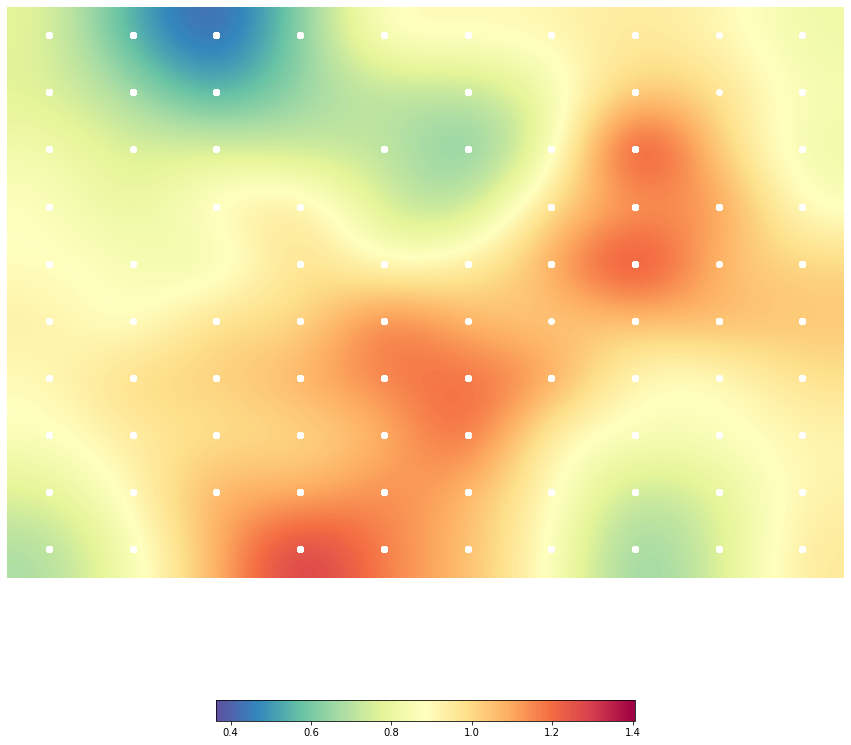

In [39]:
print(som_10.clusters)
print()
unique_values, counts = np.unique(som_10.clusters, return_counts=True)
arr = np.asarray((unique_values, counts))
sorted_arr = arr[ :, arr[1].argsort()]
print("\033[1m Clusters sorted by increasing number of neurons: \033[0m")
print("Cluster index")
print("Number of neurons")
print(sorted_arr)
print()
som_10.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()

Παρατηρούμε πολλές μπλε περιοχές clusters, με μια μεγάλη πάνω αριστερά οι οποίες χωρίζονται από μια μεγάλη διαγώνιο στην μέση.


### 6. Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Θα χρησιμοποιήσουμε την παρακάτω διαδικασία για την υλοποίηση της συνάρτησης

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.



In [40]:
def print_categories_stats(IDs):
    total_categories = []                                                                        # Αρχικοποιούμε τη συνολική λίστα κατηγοριών
    for movie_id in IDs:                                                                         # Για κάθε movie_id στην λίστα IDs
        movie_categories = categories[movie_id][0].split(",")  # list                            # Δημιουργούμε μία λίστα με τις κατηγορίες της
        for i in range(len(movie_categories)):                                                   # Σε κάθε μία από αυτές αφαιρούμε το whitespace  
            total_categories.extend([movie_categories[i].strip()])                               # και την κάνουμε extend στην συνολική λίστα κατηγοριών
    unique_categories, counts = np.unique(total_categories, return_counts=True)                  # Βρίσκουμε τις μοναδικές κατηγορίες και την συχνότητά τους
    largest_categories_indexes = np.argsort(counts)[::-1]                                        # Ταξινομούμε τις κατηγορίες σε φθίνουσα σειρά συχνοτήτων
    result = [(unique_categories[index],counts[index]) for index in largest_categories_indexes]  # Δημιουργούμε την τελική ταξινομημένη λίστα από tuples της μορφής (Category,Counts)
    print("Overall Cluster Genres stats:")                                                       # Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα
    print(result)
    return result                                                                                # Επιστρέφουμε την τελική λίστα με τις στατιστικές των κατηγοριών των ταινιών

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.



In [41]:
def print_cluster_neurons_movies_report(som,ubmus,cluster_number):
    row_indexes, column_indexes = np.where(som.clusters==cluster_number)        # Βρίσκουμε τις συντεταγμένες όλων των νευρώνων που ανήκουν στο cluster
    cluster_bmus = np.column_stack((column_indexes,row_indexes))                # Φτιάχνουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη-γραμμή) (ανάποδα από ότι στην python) στον πίνακα bmus 
    cluster_bmus_indices  = []                                                  # Αρχικοποιούμε μία λίστα με τους αριθμούς των νευρώνων
    for cluster_bmu in cluster_bmus:                                            # Για κάθε bmu 
        if (ubmus == cluster_bmu).all(axis=1).any():                            # ελέγχω αν υπάρχει στον πίνακα μοναδικών bmus (ubmus)
            bmus_number = np.where(np.all(cluster_bmu==ubmus,axis=1))[0][0]     # και αν υπάρχει βρίσκω την αντίστοιχη γραμμή
            cluster_bmus_indices.append(bmus_number)                            # και την κάνω append στην λίστα 
    return cluster_bmus                                                         # Επιστρέφω τον πίνακα  bmus για το cluster

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.




In [42]:
def neuron_movies_report(som,neurons):
    cluster_movies_ids = []                                                          # Αρχικοποιώ μία λίστα με τα IDs των ταινιών που ανήκουν στο σύνολο των νευρώνων
    for neuron in neurons:                                                           # Για κάθε νευρώνα
        if (som.bmus == neuron).all(axis=1).any():                                   # ελέγχω αν υπάρχει στον πίνακα των bmus του som
            cluster_movies_ids.append(np.where(np.all(som.bmus==neuron,axis=1))[0])  # και αν υπάρχει βρίσκω τις αντίστοιχες γραμμές οι οποίες συμπίπτουν με τα IDs των ταινιών 
    return list(itertools.chain.from_iterable(cluster_movies_ids))                   # Επιστρέφω την λίστα με τα IDs των ταινιών

Με τις συναρτήσεις έτοιμες, πάμε να δούμε τις κατηγορίες των clusters μας για όλες μας τις ταινίες, κάνοντας χρήση της `print_categories_stats`.

Ακόμη, τυπώνουμε τις 5 κατηγορίες που εμφανίζονται περισσότερο και τις 5 κατηγορίες που εμφανίζονται λιγότερο για να έχουμε μια καλύτερη εικόνα των data μας.

In [43]:
categories_stats = print_categories_stats([i for i in range(5000)])
most_frequent_categories = categories_stats[0:5]
least_frequent_categories = categories_stats[-5:]
print()
print("--------------------------------------------------------------------------------- \033[1m 5 most frequent categories \033[0m ---------------------------------------------------------------------------------")
for cat in most_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(cat[0],cat[1]))
print("--------------------------------------------------------------------------------- \033[1m 5 least frequent categories \033[0m ---------------------------------------------------------------------------------")
for cat in least_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(cat[0],cat[1]))
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Overall Cluster Genres stats:
[('"Drama"', 2323), ('"Comedy"', 1185), ('"Thriller"', 819), ('"Romance Film"', 817), ('"Action"', 729), ('"World cinema"', 584), ('"Crime Fiction"', 513), ('"Horror"', 483), ('"Action/Adventure"', 444), ('"Black-and-white"', 436), ('"Indie"', 431), ('"Adventure"', 411), ('"Short Film"', 389), ('"Family Film"', 361), ('"Romantic drama"', 308), ('"Musical"', 297), ('"Science Fiction"', 296), ('"Animation"', 276), ('"Mystery"', 263), ('"Fantasy"', 242), ('"Comedy film"', 231), ('"Romantic comedy"', 229), ('"Crime Thriller"', 207), ('"War film"', 177), ('"Comedy-drama"', 166), ('"Period piece"', 161), ('"Silent film"', 148), ('"Film adaptation"', 147), ('"Western"', 140), ('"Documentary"', 139), ('"Japanese Movies"', 137), ('"Psychological thriller"', 133), ('"Bollywood"', 124), ('"Chinese Movies"', 118), ('"Black comedy"', 99), ('"Teen"', 92), ('"Family Drama"', 90), ('"Suspense"', 90), ('"Television movie"', 88), ('"Children\'s/Family"', 88), ('"Coming of a

Αφού λοιπόν έχουμε ετοιμάσει τις συναρτήσεις για την μελέτη των clusters και έχουμε μια καλύτερη εικόνα για τα στατιστικα μας, θα ετοιμάσουμε μια ακόμα συνάρτηση ωστε να κάνουμε τους ελέγχους για τις διαφορετικές διαστάσεις των SOMs σε συνδιασμό με διαφορετικό αριθμό k για τον k-Means.

H συνάρτηση θα δέχεται σαν ορίσματα τον χάρτη SOM, τα αντίστοιχα unique bmus, και το k και κάνοντας χρήση των 3 βοηθητικών συναρτήσεων που ορίσαμε παραπάνω θα μας επιστρέφει τα στατιστικά για τον κάθε συνδιασμό.

Στην συνέχεια θα μελετήσουμε αυτά τα στατιστικά και θα καταλήξουμε στις βέλτιστες παραμέτρους με τις οποίες θα κάνουμε την επεξεργασία στο final set.

In [44]:
np.set_printoptions(linewidth=np.inf)                                           # Για να εμφανίζεται μία γραμμή του πίνακα στην ίδια σειρά και να μην πηγαίνει από κάτω 

def som_testing(som,unique_bmus,k):
    som.cluster(KMeans(n_clusters=k))                                           # Εφαρμόζουμε τον αλγόριθμο συσταδοποίησης KMeans με k γείτονες
    print("-------------------------------------------------------------- k = {}  --------------------------------------------------------------".format(k))
    print("\n")
    print("Som Clusters")
    print(som.clusters)                                                         # Τυπώνουμε απευθείας τη μεταβλητή clusters για μία πιο ξεκάθαρη απεικόνιση του clustering
    print("\n")
    unique_values, counts = np.unique(som.clusters, return_counts=True)         # Βρίσκουμε τις μοναδικές συστάδες και τις συχνότητές τους
    arr = np.asarray((unique_values, counts))                                   # Φτιάχνουμε έναν πίνακα με τον αριθμό των συστάδων στην πρώτη γραμμή και τις ανίστοιχες συχνότητές τους στην δεύτερη
    sorted_arr = arr[ :, arr[1].argsort()]                                      # Ταξινομούμε τον πίνακα σε αύξουσα σειρά συχνοτήτων (αριθμού νευρώνων)
    print("\033[1m Clusters sorted by increasing number of neurons:\033[0m")
    print("Cluster index")
    print("Number of neurons")
    print(sorted_arr)                                                           # Τυπώνουμε τον ταξινομημένο πίνακα
    print()
    for i in range(k):                                                          # Για κάθε cluster από τα k που σχηματίζει ο αλγόριθμος τυπώνουμε την στατιστική των κατηγοριών των ταινιών που ανήκουν σε αυτό
        print("---------------------------------------------------------------------------------\033[1m Cluster {} \033[0m---------------------------------------------------------------------------------".format(i))
        print()
        cluster_coordinates = print_cluster_neurons_movies_report(som,unique_bmus,i)
        cluster_movies_ids = neuron_movies_report(som,cluster_coordinates)
        _ = print_categories_stats(cluster_movies_ids)
        print()
    som.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()  # Τυπώνουμε τον U-Matrix

### 7. Optimization testing

Ξεκινάμε με την `som_testing` για χάρτες: 20x20, 25x25, 30x30 και k: 15, 20, 25, 30, 35, 40

#### SOM: 20x20

##### k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[12 12 12 12 12  9 14 14 14  9  9  3  3  3  3  7  7  7  7  7]
 [12 12 12 12 12  9  9  9  9  9  9  3  3  3  3  7  7  7  7  7]
 [12 12 12 12  9  9  9  9  9  9  9  3  3  3  3  7  7  7  7  7]
 [12 12 12 12 12  9 12  9  9  9  9  3  3  3  7  7  7  7  7  7]
 [12 12 12 12 12 12 12 12 12  9  9  1  1  1  1  7  7  7  8  8]
 [12 12 12 12 12 12 12 12  4  4  1  1  1  1  1  1  8  8  8  8]
 [12 12 12 12 12 12 12  4  4  4  1  1  1  1  1  1  8  8  8  8]
 [ 2  2 12 12 12 12 12  4  4  1  1  1  1  1  1  5  8  8  8  8]
 [ 2  2  2 12 12 12  4  4  1  1  1  1  1  1  5  5  5  8  8  8]
 [ 2  2  2  2 12  4  4  4  4  4  1  1  1  1  5  5  5  5  8  8]
 [ 2  2  2  2  2  4  4  4  4  4  4  4  4  4  5  5  5  5  8  8]
 [ 2  2  2  2  4  4  4  4  4  4  4  4  4  4  5  5  5  5  8  8]
 [14 14  2  2  4  4  4  4  4  4  4  4  4  4  4  4 10 10 10 10]
 [14 14 14  4  4  4  4  4  4  4 

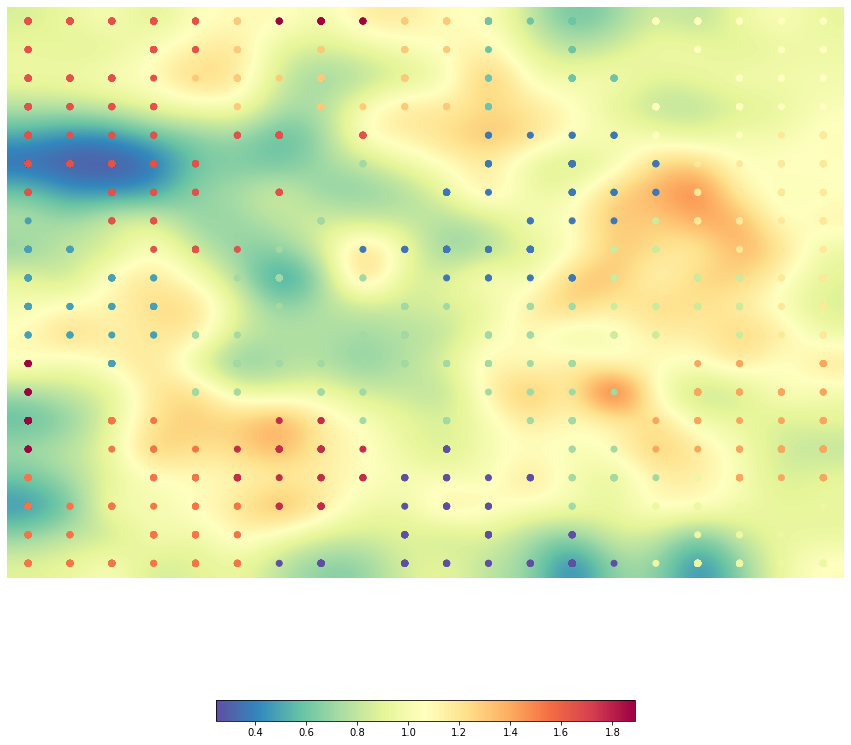

In [ ]:
som_testing(som_20,unique_bmus_20,15)

##### k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[ 2  2  2  2  2 14 14 14 14 14 14 18 18 18 18  1  1  1  1  1]
 [ 2  2  2  2  8  8 14 14 14 14 14 18 18 18 18  1  1  1  1  1]
 [ 2  2  2  2  8  8 14 14 14 14 14 18 18 18 18  2  1  1  1  1]
 [ 2  2  2  2  2  8  0 14 14 14 14 18 18 18  2  2  1  1  1  1]
 [ 2  2  2  2  2  0  0  0  0 14 14 19 19 19 19 19 19  1  9  9]
 [ 2  2  2  2  2  2  0  0  0  0  7 19 19 19 19 19 19  9  9  9]
 [ 2  2  2  2  2  0  0  0  0  0  7  7 19 19 19 19 15  9  9  9]
 [ 4  4  2  2  2  2  0  0  0  7  7  7  7 19 15 15 15  9  9  9]
 [ 4  4  4  2  2  2 12  0  7  7  7  7  7  7 15 15 15  9  9  9]
 [ 4  4  4  4  2 12 12 12 12 12  7  7  7  7 15 15 16 16  9  9]
 [ 4  4  4  4  4 12 12 12 12 12 12 12 12  7 15 16 16 16  9  9]
 [ 4  4  4  4  3  3  3 12 12 12 12 12 12 12 12 12 16 17 17 17]
 [ 4  4  4  4  3  3  3 12 12 12 12 12 12 12 12 12 17 17 17 17]
 [13 13 13  3  3  3  3 12 12 12 

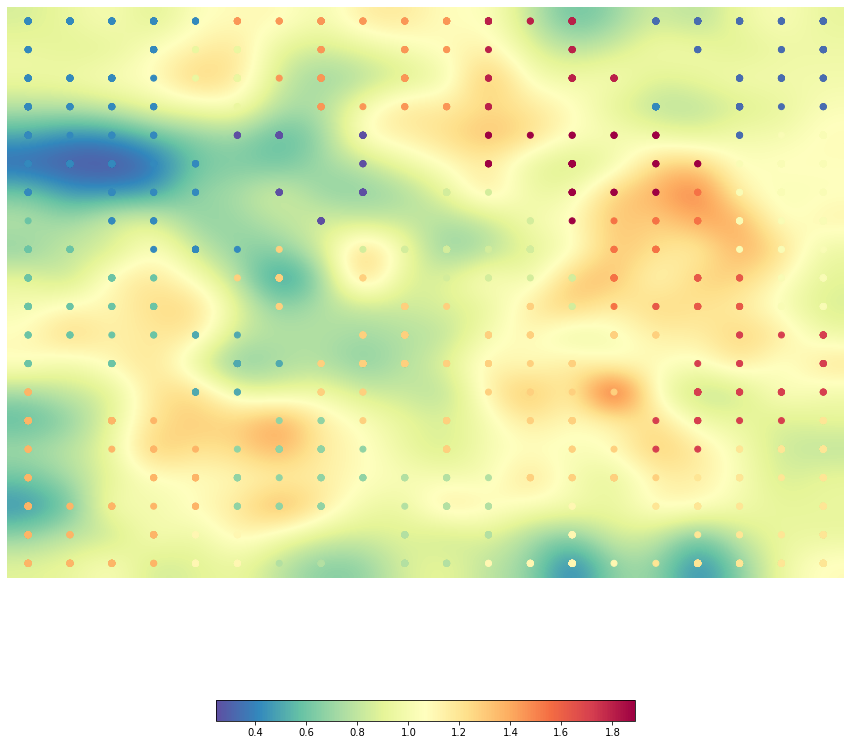

In [ ]:
som_testing(som_20,unique_bmus_20, 20)

##### k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[ 1  1  1  1 14 19 19 19 19 11 11 11 22 22 22 22  5  5  5  5]
 [ 1  1  1  1  1 10 19 19 19 19 11 11 22 22 22 22  5  5  5  5]
 [ 1  1  1  1 10 10 10 19 19 17 17 17 22 22 22  5  5  5  5  5]
 [ 1  1  1  1  1 10 14 14 14 17 17 17 22 22  5  5  5  5  5  5]
 [ 1  1  1  1  1 14 14 14 14 14 17 17 12 12 12  5  5  5 20 20]
 [ 1  1  1  1  1 14 14 13 13 13 12 12 12 12 12 12 20 20 20 20]
 [ 1  1  1  1  1 14 14 13 13 13 12 12 12 12 15 15 15 20 20 20]
 [ 1  1  1  1  1  1 13 13 13 12 12 12 12 12 15 15 15 20 20 20]
 [16 16 16  1  1 24 24 24 24 12 12 12 12 12 15 15 15  2  2  2]
 [16 16 16 16  1 24 24 24 24  0 12 12 12 12 15 15  8  8  2  2]
 [16 16 16 16 16 24 24 24  0  0  0  0  0  0 15  8  8  8  2  2]
 [16 16 16 16 21 21 21  0  0  0  0  0  0  0  0  0  8  8  2  2]
 [ 4  4 14 16 21 21 21  0  0  0  0  0  0  0  0  0 23 23 23 23]
 [ 4  4  4 21 21 21 21  0  0  0 

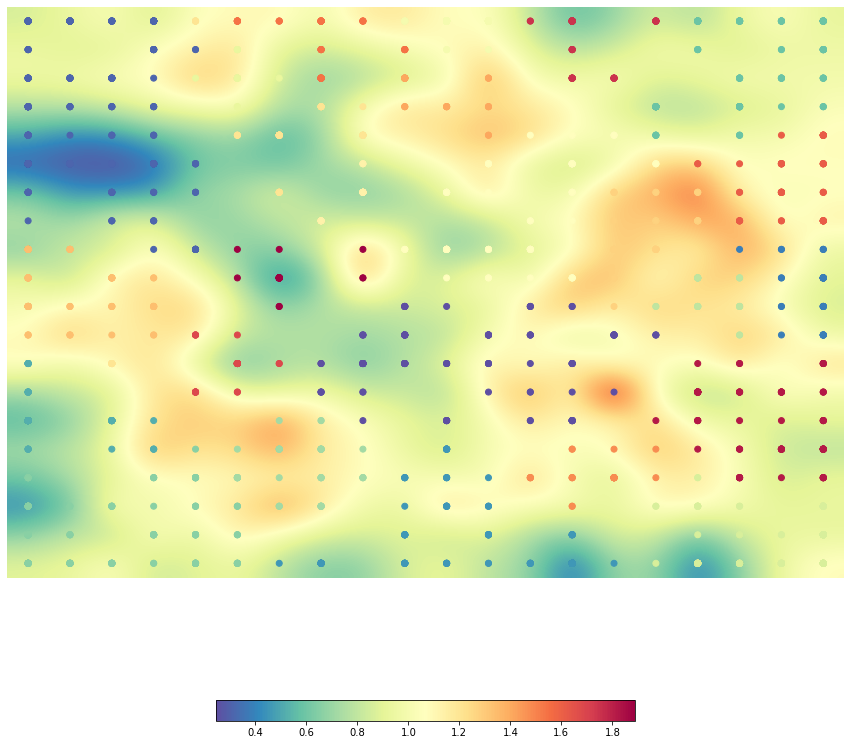

In [ ]:
som_testing(som_20,unique_bmus_20, 25)

##### k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[14 14 28 28 28  6  6  6  6  5  5  5 26 26 26  7  7  7  8  8]
 [14 14 28 28 28  6  6  6  6  5  5  5 26 26 26  7  7  8  8  8]
 [14 14  0  0  6  6  6  6  6  5  5  5 26 26 26 24  8  8  8  8]
 [14 14 14  0  0  6 16  6  6  5  5  5 26 26 24 24 24  8  8  8]
 [14 14 14 14 14 16 16 16 16  6  5 13 13 13 24 24 24  8  8  8]
 [14 14 14 14 14 14 16 16 16 16 23 13 13 13 13 24 24  2  2  2]
 [14 14 14 14 14 16 16 16 16 16 23 23 13 13 13 18 25  2  2  2]
 [20 20 14 14 14 14 16 16 16 23 23 23 23 13 18 25 25  2  2  2]
 [20 20 20 14 14  9  9  9  9 23 23 23 18 18 25 25 25  2  2  2]
 [20 20 20 20 14  9  9  9  9 27 23 23 18 18 25 25 12 12  2  2]
 [20 20 20 28 28  9  9  9 27 27 27 27 18 18 25 25 12 12  2  2]
 [20 20 20 28  1  1  1 27 27 27 27 27 18 19 25 25 12  7  2  2]
 [11 11 11 20  1  1  1 27 27 27 27 27 19 19 19 27  7  7  7 22]
 [11 11 11  1  1  1  1 27 27 27 

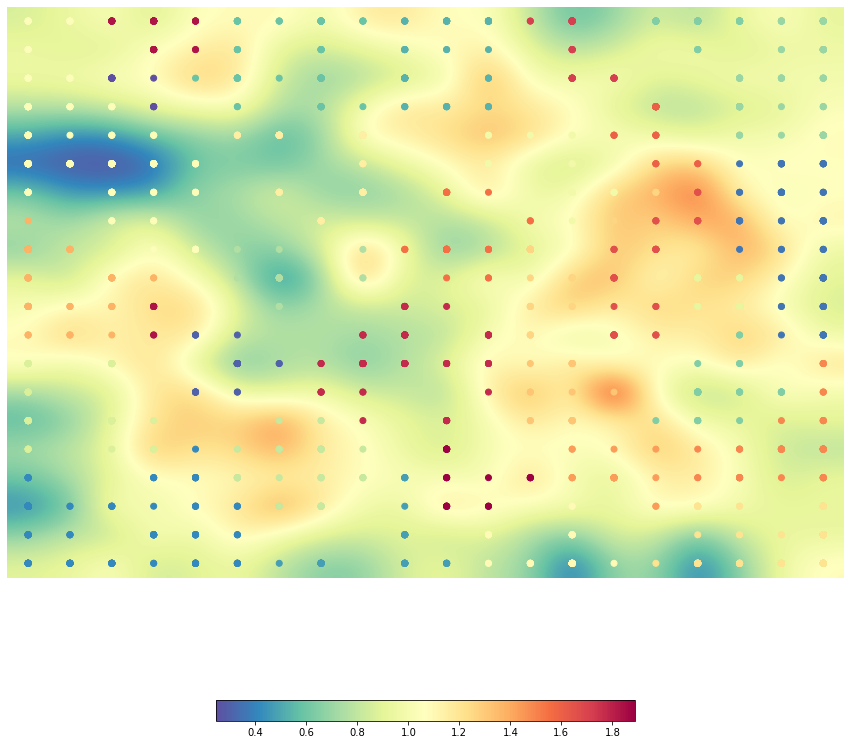

In [ ]:
som_testing(som_20,unique_bmus_20, 30)

#### SOM: 25x25

##### k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[ 9  9  9  7  7  7  7  9 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13]
 [ 9  9  9  7  7  7  7  9 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13]
 [ 9  9  9  9  7  7  7 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13 13]
 [ 9  9  9  9  9  7 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 13 13 13 13]
 [ 9  9  9  9  9  7 14 14  5  5 14 14 14  5 14 14 14 14 14 14 14 13 13 13 13]
 [ 9  9  9  9  9  9 14 14 14  5  5  5  5  5  5 14 14 14 14 14 14 13 13 13 13]
 [ 9  9  9  9  9  1  1  1  1  5  5  5  5  5 12 12 12 12 14 10 10 13 13 13 13]
 [ 9 11 11  9  1  1  1  1  1  5  5  5  5 12 12 12 12 12 10 10 10  6 13 13 13]
 [11 11 11 11  1  1  1  1  1  5  5  5  5 12 12 12 12 10 10 10 10 10 13 13 13]
 [11 11 11  1  1  1  1  1  1  1  8  8  8 12 12 12 12 10 10 10 10 10  6 13 13]
 [11 11 11 11  1  1  1  1  1  8  8  8  8 12 12 12 12 10 10 10 10 10  6 

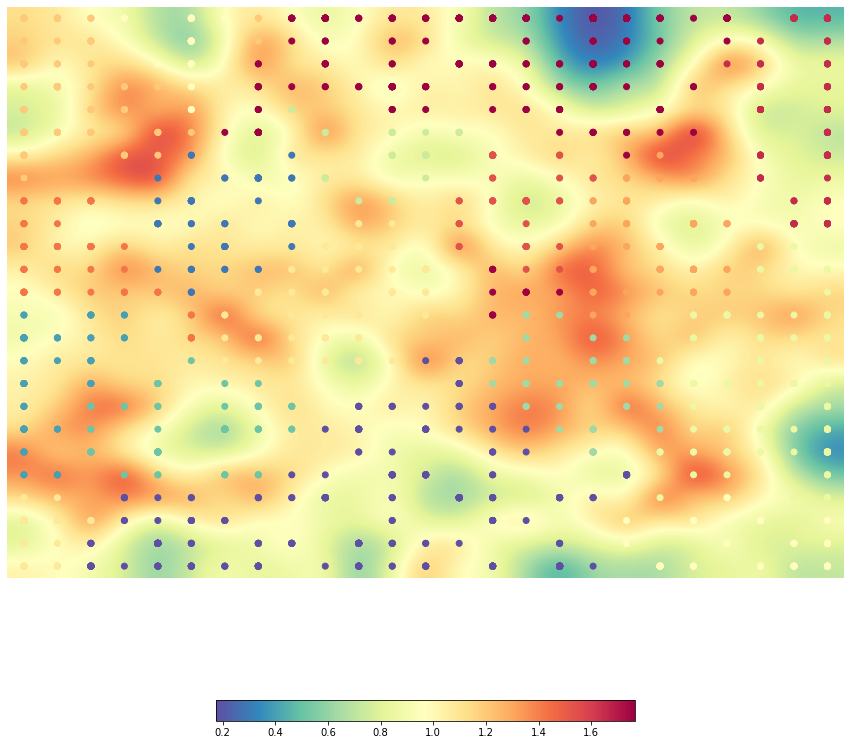

In [ ]:
som_testing(som_25,unique_bmus_25, 15)

##### k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[ 4  4  4  7 17 17 17  8  8  8  8  8 17 17 17 17 17 17 17 17 17 17  3  3  3]
 [ 4  4  4  7 17 17 17  8  8  8  8  8 17 17 17 17 17 17 17 17 17 17  3  3  3]
 [ 4  4  4  4 17 17 17  8  8  8  8 17 17 17 17 17 17 17 17 17 17  3  3  3  3]
 [ 4  4  4  4  4 17  8  8  8  8 17 17 17 17 17 17 17 17 17 17 17  3  3  3  3]
 [ 4  4  4  4  4  6  6  6  6  1 17 17 17  1 17 17 17 17 17 17 17  3  3  3  3]
 [ 4  4  4  4  4  6  6  6  6  6  1  1  1  1  1 17 17 17 17 17 17  3  3  3  3]
 [ 4  4  4  4  4  6  6  6  6  6  1  1  1  1  1  1 11 11 17 18 18  3  3  3  3]
 [ 4  6  6  4 16 16  6  6  6  6  6  1  1  1  1 11 11 11 18 18 18 13  3  3  3]
 [ 6  6  6  6 16 16 16  6  6  6 19  1  1 11 11 11 11 18 18 18  2  2 13 13 13]
 [ 9  9  9 16 16 16 16 16  6 19 19 19 19 11 11 11 11 18 18 18  2  2 13 13 13]
 [ 9  9  9  9 16 16 16 16 19 19 19 19 19 19 11 11 11 18 18  2  2  2 13 

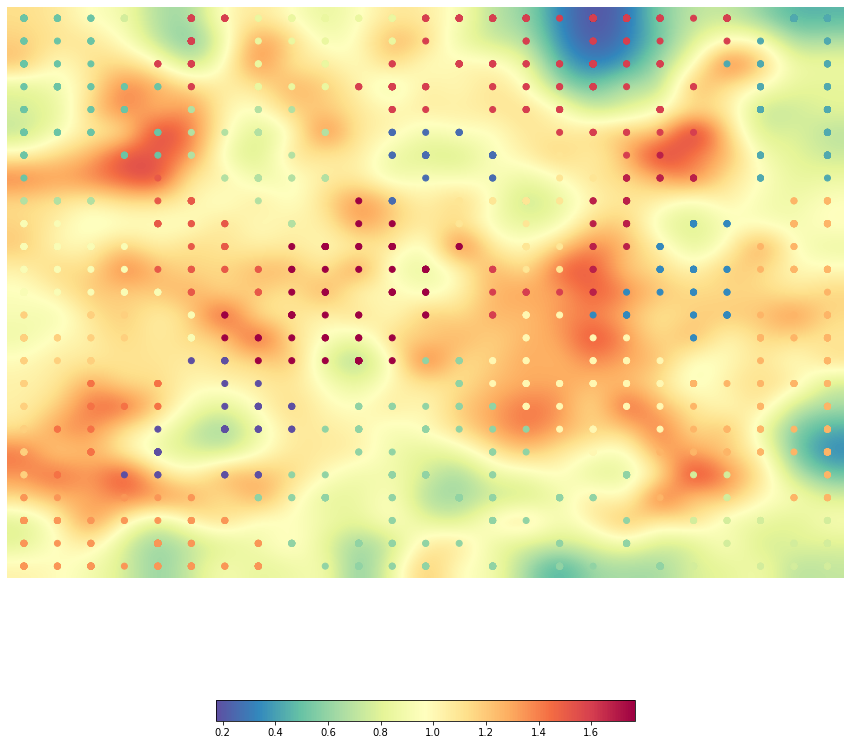

In [ ]:
som_testing(som_25,unique_bmus_25, 20)

##### k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[ 6  6  6  8  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 15 15 15]
 [ 6  6  6  8  1  1  1 22  1  1  1 22  1  1  1  1  1  1  1  1  1  1 15 15 15]
 [ 6  6  6  6  1  1  1 17 22 22 22 22 22  1  1  1  1  1  1  1  1 15 15 15 15]
 [ 6  6  6  6  6 22 17 17 17 22 22 22 22  1  1  1  1  1  1  1  1 15 15 15 15]
 [ 6  6  6  6  6 17 17 17 17 17 22 22 22 14  1  1  1  1  1  1  1 15 15 15 15]
 [ 6  6  6  6  6  6 17 17 17 17 14 22 14 14 14  1  1  1  1  1  1 15 15 15 15]
 [ 6  6  6  6  6 21 17 17 17 21 14 14 14 14 14 14 16  1  1 18 18 15 15 15 15]
 [ 6 17 21  6 21 21 21 21 21 21 21 14 14 14 14 16 16 16 16 18 18 20 20 20 15]
 [17 17 21 21 21 21 21 21  7 21  3  3 14 16 16 16 16 16 16 18 18 18 20 20 20]
 [ 0  0  0 21 21 21  7  7  7  7  7  3  3  3 16 16 16 16 16 18 18 18 20 20 20]
 [ 0  0  0  0 21  7  7  7  7  7  7  3  3  3 16 16 16 16 18 18 18 18 20 

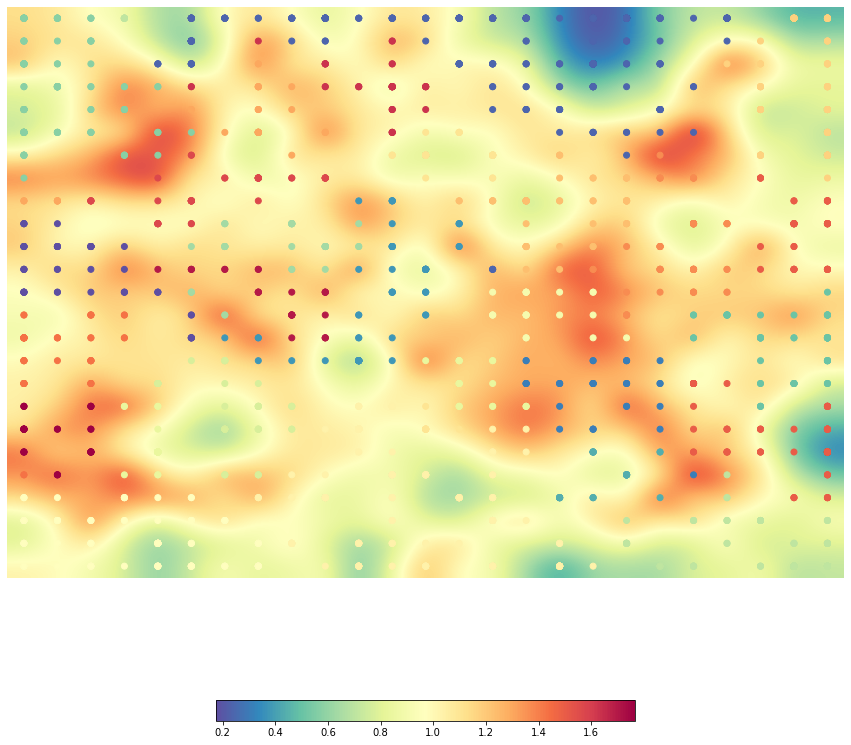

In [ ]:
som_testing(som_25,unique_bmus_25, 25)

##### k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[13 13 13  1  1  1  1 28 28 28 28 12 17 17 17 17 17 17 17 17 17 17 19 19 19]
 [13 13 13 13  1  1  1 28 28 28 28 12 17 17 17 17 17 17 17 17 17 17 19 19 19]
 [13 13 13 22  1  1  1 28 28 28 17 17 17 17 17 17 17 17 17 17 17 19 19 19 19]
 [13 13 13 22 22  1 28 28 28 28 17 17 17 17 17 17 17 17 17 17 17 19 19 19 19]
 [22 22 22 22 22  1 28 28 28 26 17 17 17 11 17 17 17 17 17 17 17 19 19 19 19]
 [22 22 22 22 27 27 28 28 28 26 26 26 26 11 11 17 17 17 17 17 17 19 19 19 19]
 [22 22 22 27 27  8  8  8  3  3 26 26 26 11 11 11 21 21 17  2  2 16 16 16 16]
 [22 20 20 27  8  8  8  8  3  3  3 26 26 11 11 21 21 21  2  2  2 14 16 16 16]
 [20 20 20 20  8  8  8  8  6  3  3 26 26 21 21 21 21  2  2  2  2  2 16 16 16]
 [23 20 23  8  8  8  8  6  6  6  6 18 18 21 21 21 21  2  2  2  2  2 16 16 16]
 [23 23 23 23  8  8  8  6  6  6  6 18 18 18 21 21 21  2  2  2  2  2  2 

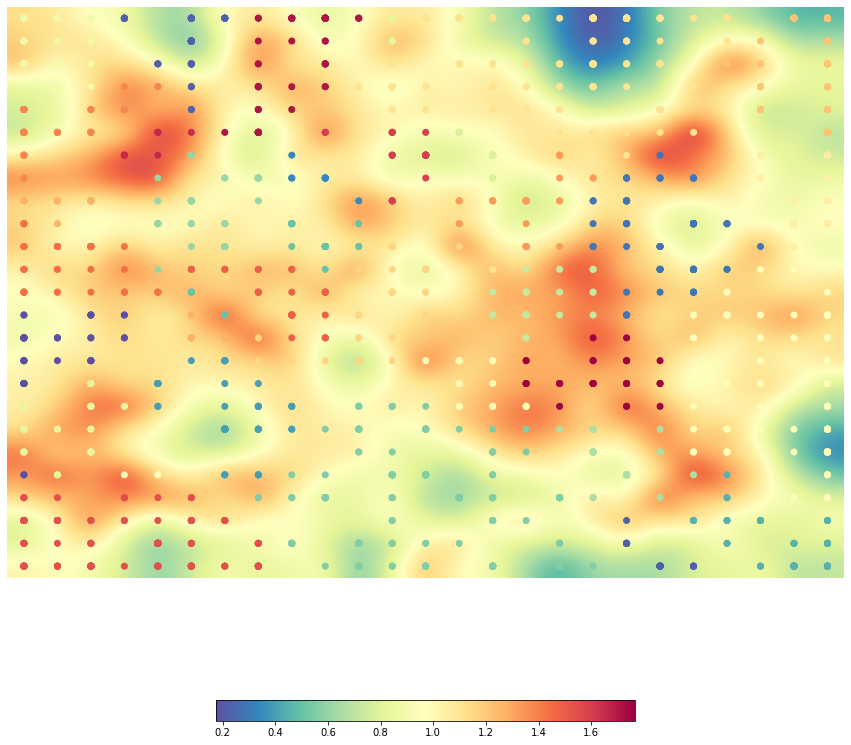

In [ ]:
som_testing(som_25,unique_bmus_25, 30)

##### k = 35

-------------------------------------------------------------- k = 35  --------------------------------------------------------------


Som Clusters
[[ 2  2  2 17  8  8  8  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1 16 16 16]
 [ 2  2  2  2  8  8  8  2  1  1  1 31  1  1  1  1  1  1  1  1  1  1 16 16 16]
 [ 2  2  2  2  8  8  8 26 31 31 31 31 31  1  1  1  1  1  1  1  1 16 16 16 16]
 [ 2  2  2 13  8  8 26 26 26 31 31 31 31  1  1  1  1  1  1  1  1 16 16 16 16]
 [ 2  2 13 13 13  8 26 26 26 26 31 31 31 21  1  1  1  1  1  1  1 16 16 16 16]
 [ 2  2 13 13 13 26 26 26 26 26 21 31 21 21 21  1  1  1  1  1  1 16 16 16 16]
 [ 2  2 13 13 13 26 26 26 26 26 21 21 21 21 21 21 25  1  1 12 12 16 16 16 16]
 [ 2 11 11 13 20 20 26 26 26 26 26 21 21 21 21 25 25 25 12 12 12 29 16 16 16]
 [11 11 11 11 20 20 20 26 26 26 21 21 21 25 25 25 25 12 12 12 12 12  0  0  0]
 [11 11 11 20 20 20  5  5 10 10 10 10 10 25 25 25 25 12 12 12 12 12  0  0  0]
 [11 11 11 11 20  5  5  5 10 10 10 10 10 10 25 25 25 12 12 12 12 12  0 

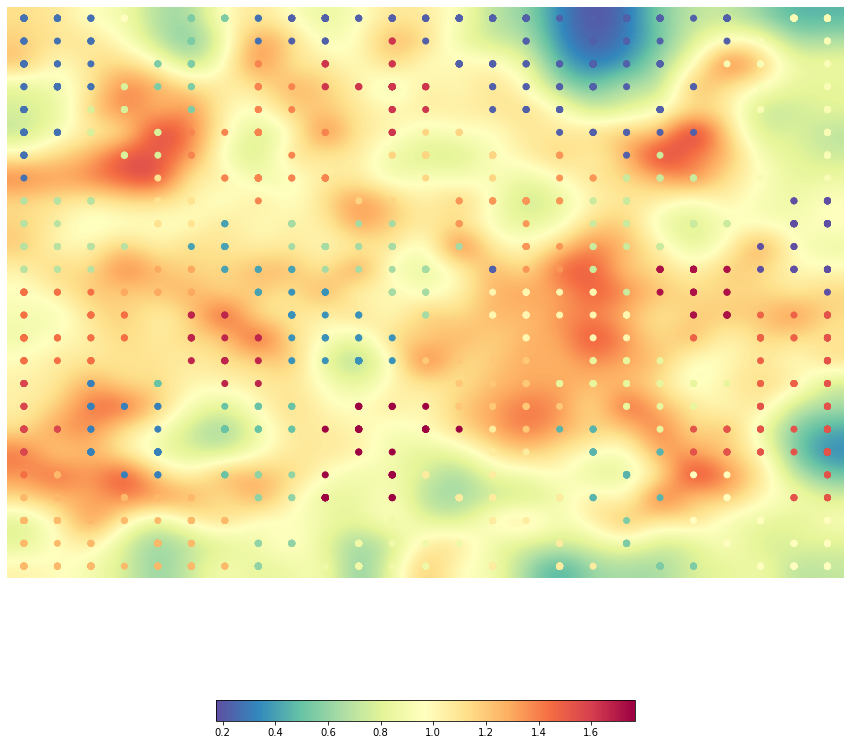

In [ ]:
som_testing(som_25,unique_bmus_25, 35)

##### k = 40

-------------------------------------------------------------- k = 40  --------------------------------------------------------------


Som Clusters
[[25 25 25 17 17 17 17 17  5  5  5  5  5  5  5  5  5  5  5  5  5  5 16 16 16]
 [25 25 25 25 17 17 17 17  5  5  5 37  5  5  5  5  5  5  5  5  5  5 16 16 16]
 [28 28 28 28 17 17 17 23 23 37 37 37 37  5  5  5  5  5  5  5  5 16 16 16 16]
 [28 28 28 12 17 17 23 23 23 37 37 37 37  5  5  5  5  5  5  5  5 16 16 16 16]
 [28 28 12 12 12 23 23 23 23 35 37 37 37 35  5  5  5  5  5  5  5 16 16 16 16]
 [28 28 12 12 12 23 23 23 23 35 35 35 35 35 35  5  5  5  5  5  5 16 16 16 16]
 [28 28 12 12 12 23 23 23 23 27 35 35 35 35 35 35  3  5  5 11 11 16 16 16 16]
 [28 15 15 12 34 34 34 34 27 27 27 35 35 35 35  3  3  3 11 11 11  0 16 16 16]
 [15 15 15 15 34 34 34 34  4 27 27 35 35  3  3  3  3 11 11 11 11 11 33 33 33]
 [15 15 15 34 34 34  4  4  4 29 29 36 36  3  3  3  3 11 11 11 11 11 33 33 33]
 [ 7  7  7  7 34  4  4  4 29 29 29 36 36  3  3  3  3 11 11 11 11 11 33 

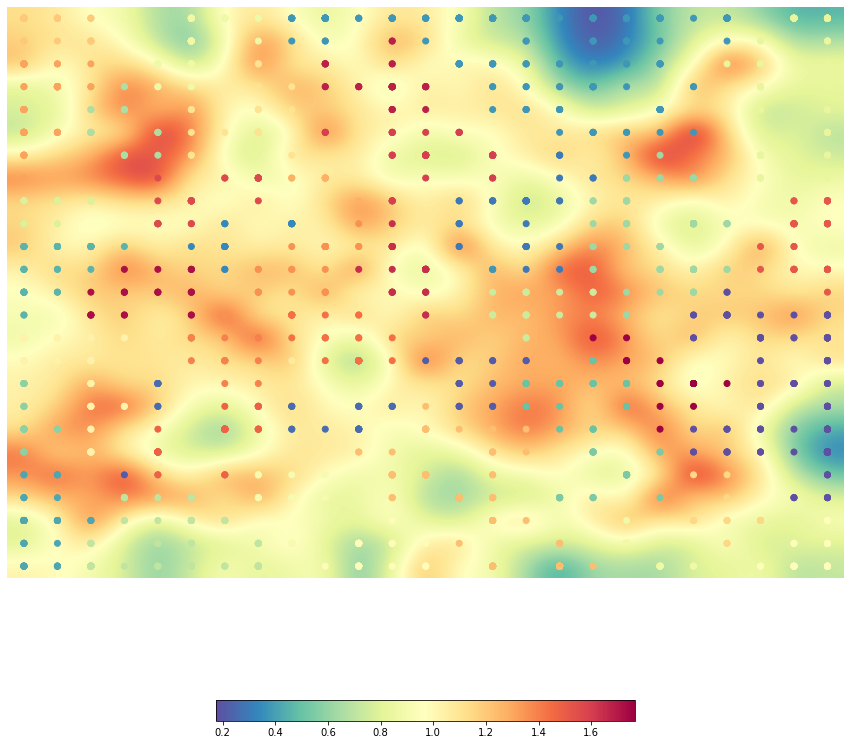

In [ ]:
som_testing(som_25,unique_bmus_25, 40)

#### SOM: 30 x 30

##### k = 15

-------------------------------------------------------------- k = 15  --------------------------------------------------------------


Som Clusters
[[ 8  8  8  8  2  2  2  2  2  2  1  1  1  1  1  1 11 11 11 11 11 11 11 11 11 11  7  7  7  7]
 [ 8  8  8  8  2  2  2  2  2 13  1  1  1  1  1  1  1 11 11 11 11 11 11 11 11 11  7  7  7  7]
 [ 8  8  8  8  8  2  2  2  2 13  1  1  1  1  1  1  1 11 11 11 11 11 11 11 11 11  7  7  7  7]
 [ 8  8  8  8  8  8  8  2 13  1  1  1  1  1  1  1  1 11 11 11 11 11 11 11 11 11  7  7  7  7]
 [ 8  8  8  8  8  8  8  8 13 13  1  1  1  1  1  1  1  1 11 11 11 11 11 11 11  7  7  7  7  7]
 [14 13  8  8  8 13 13 13 13 13 13  1  1 13  1  1  1  1 11 11 11 11 11 11 11  7  7  7  7  7]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  1  1 13  1 11 11 11 11 11 11  7  7  7  7  7]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  9  6  6  6  6  6  6  7  7  7  7  7]
 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13  9  6  6  6  6  6  6  6  7  7  7  7]
 [10 10 10 13 

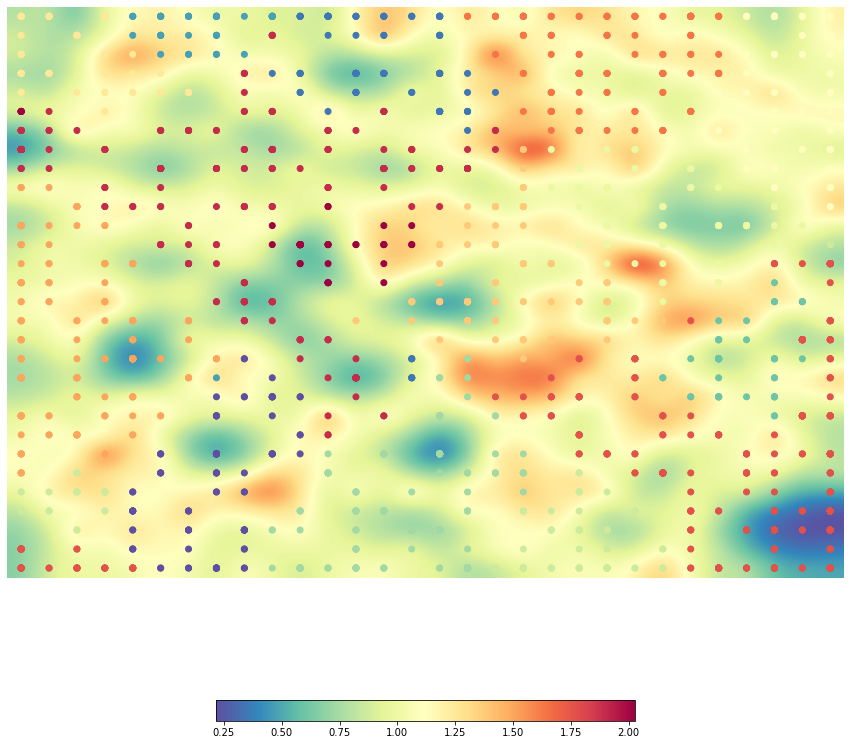

In [ ]:
som_testing(som_30,unique_bmus_30, 15)

##### k = 20

-------------------------------------------------------------- k = 20  --------------------------------------------------------------


Som Clusters
[[12 12 12 12 12 11 11 11 11  7  7  7  7 10  6  6  6  6  6  6  6  6  6  6  6  6  8  8  8  8]
 [12 12 12 12 12 11 11 11 11  7  7  7 10 10  6  6  6  6  6  6  6  6  6  6  6  6  8  8  8  8]
 [12 12 12 12 12  5  5 11  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6 13  8  8  8]
 [12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6 13 13 13 13 13]
 [12 12 12 12 12 12 12 12  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6 13 13 13 13 13]
 [19 12 12 12 12  7  7  7  7  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6 13 13 13 13 13]
 [12 12 14  0  7  7  7  7  7  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6 13 13 13 13 13]
 [12 12  0  0  0  7  7  7  7  7  7  7  7  7  7  7  7  7 18  1  1  1  1  1  1 13 13 13 13 13]
 [12 12  0  0  7  7  7  7  7  7  7  7  7  7  7  7  7  7 18  1  1  1  1  1  1  1 13 13 13 13]
 [ 5  0  0  0 

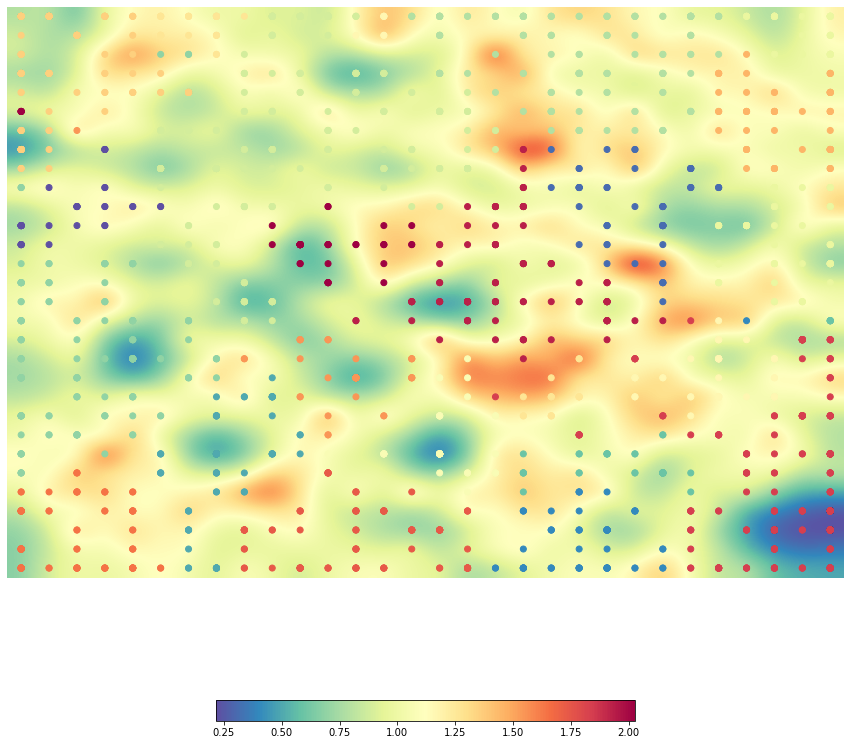

In [ ]:
som_testing(som_30,unique_bmus_30, 20)

##### k = 25

-------------------------------------------------------------- k = 25  --------------------------------------------------------------


Som Clusters
[[21 21 21 21  1  1  1  1  1  1  2  2  2  2 19 19 19 19 19 18 18 18 16 16 16 16 16 11 11 11]
 [21 21 21 21  1  1  1  1  1 23  2  2  2  2 19 19 19 19 19 18 18 18 16 16 16 16 11 11 11 11]
 [21 21 21 21 21  1  1  1  1 23  2  2  2  2  2 19 19 19 19 18 18 18 16 16 16 16 11 11 11 11]
 [21 21 21 21 21 21 21  1 23  2  2  2  2  2  2 19 19 19 18 18 18 18 16 16 16 16 11 11 11 11]
 [ 8  8 21 21 21 21 21 23 23 23  2  2  2  2  2 19 19 19 18 18 18 18 18 16 16 16 11 11 11 11]
 [ 8  8  8 21 21 23 23 23 23 23 23  2 23 23 23 19 19 19 18 18 18 18 18 16 16 16 11 11 11 11]
 [ 8  8  8  8 23 23 23 23 23 23 23 23 23 23 23 19 19 19 24 18 18 18 18  2 16 11 11 11 11 11]
 [ 8  8  8  8  8 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 18  6  6  6  6  6  6 11 11 11]
 [ 8  8  8  8 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24  6  6  6  6  6 11 11 11 11]
 [ 8  8 22 22 

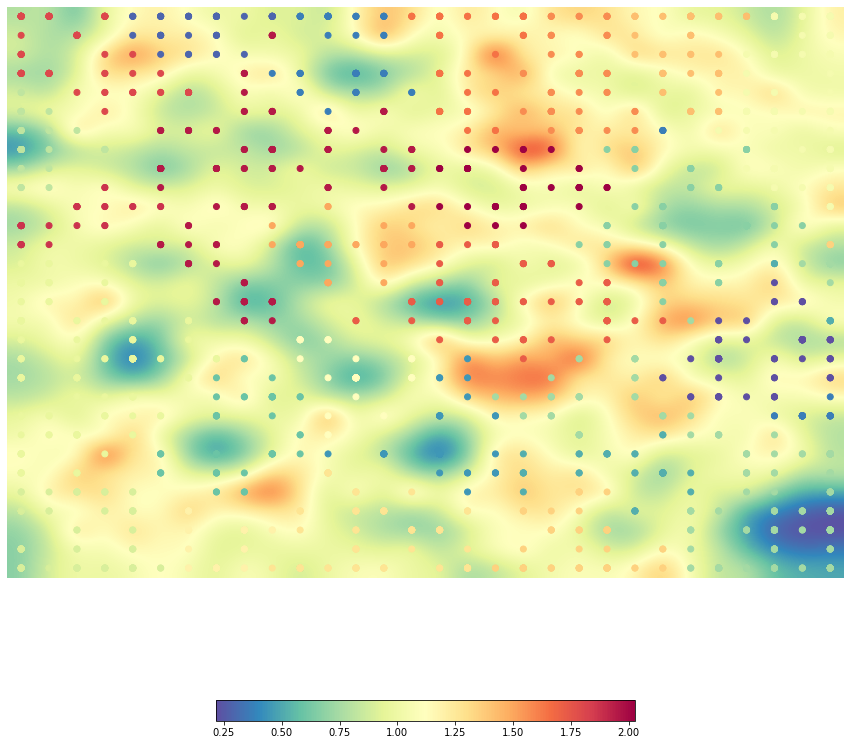

In [ ]:
som_testing(som_30,unique_bmus_30, 25)

##### k = 30

-------------------------------------------------------------- k = 30  --------------------------------------------------------------


Som Clusters
[[13 13 13 13 14 14 14 14 14 14  4  4  4 11 11 11 18 18 18 18 18 28 10 10 10 10 10 26 26 26]
 [13 13 13 13 14 14 14 14 14 23  4  4  4 11 11 11 11 18 18 18 28 28 10 10 10 10 26 26 26 26]
 [13 13 13 13 14 14 14 14 14 23  4  4  4  4 11 11 11 18 18 28 28 28 10 10 10 10 26 26 26 26]
 [13 13 13 13 13 13 13 23 23  4  4  4  4  4  4 11 11 11 28 28 28 28 10 10 10 10 26 26 26 26]
 [22 13 13 13 13 13 13 23 23 23  4  4  4  4  4 11 11 11 28 28 28 28 28 10 10 10 26 26 26 26]
 [22 22 13 13 13 23 23 23 23 23 23  4 23 23 11 11 11 15 28 28 28 28 28 10 10 10  1  1  1  1]
 [22 22 22 22 23 23 23 23 23 23 23 23 23 23 15 11 15 15 15 28 28 28 28  4 10  1  1  1  1  1]
 [22 22 22 22 22 23 23 23 23 23 23 23 23 15 15 15 25 15 25 25 28 17 17 27 17  1  1  1  1  1]
 [22 22 22 22 23 23 23 23 23 23 23 23 15 15 15 15 25 25 25 25 25 17 17 17 17 17  1  1  1  1]
 [22 22  6  6 

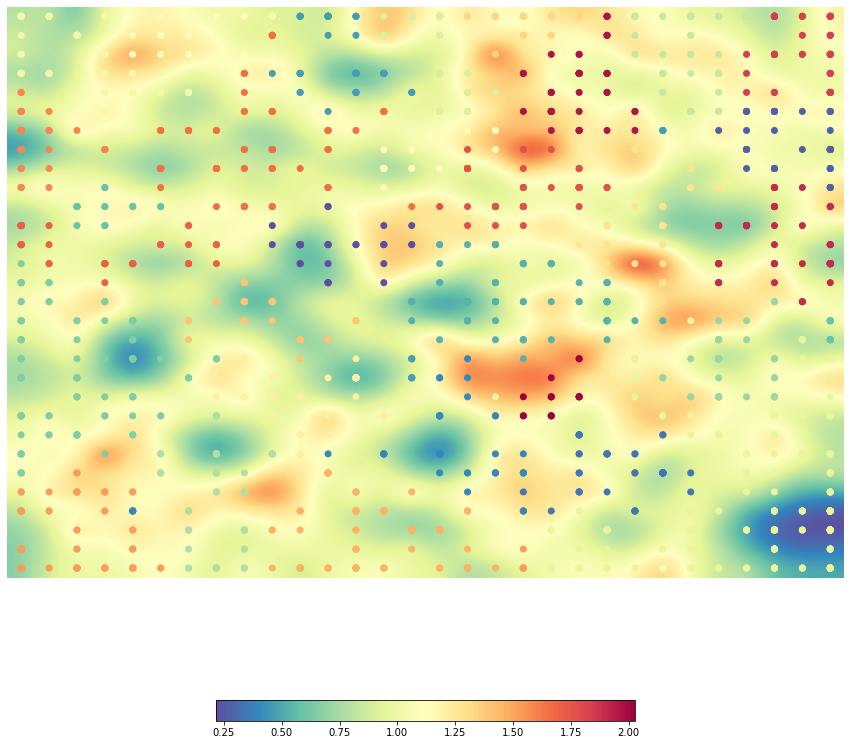

In [ ]:
som_testing(som_30,unique_bmus_30, 30)

##### k = 35

-------------------------------------------------------------- k = 35  --------------------------------------------------------------


Som Clusters
[[18 18 18 17 17 17 17 17 17  6  9  9  9 19 19 19 19 34 34 34 20 20  4  4  4  4 15 15 15 15]
 [18 18 18 18 17 17 17 17 17  6  9  9  9 14 19 19 19 34 34 34 20 20  4  4  4  4 15 15 15 15]
 [18 18 18 18 17 17 17 17  6  6  9  9  9  9 19 19 19 34 34 20 20 20  4  4  4  4 15 15 15 15]
 [18 18 18 18 18  1  6  6  6  9  9  9  9  9  9 19 19 19 20 20 20 20  4  4  4  4  7 15  7  7]
 [18 18 18 18 18  6  6  6  6  6  9  9  9  9  9 19 19 19 20 20 20 20 20  4  4  7  7  7  7  7]
 [18 18 18 18 18  6  6  6  6  6  6  9  6  6 19 19 19 28 20 20 20 20 20  4  4  7  7  7  7  7]
 [18 18 18 18  6  6  6  6  6  6  6  6  6  6 28 19 19 28 28 20 20 20 20  9  4  7  7  7  7  7]
 [18 18 18 18 18  6  6  6  6  6  6  6  6 28 28 28  8 28  8  8  8  0  0  0  0 10 10 10 10 10]
 [18 18 18 18  6  6  6  6  6  6  6  6 28 28 28 28  8  8  8  8  8  0  0  0  0  0 10 10 10 10]
 [18 25 25 25 

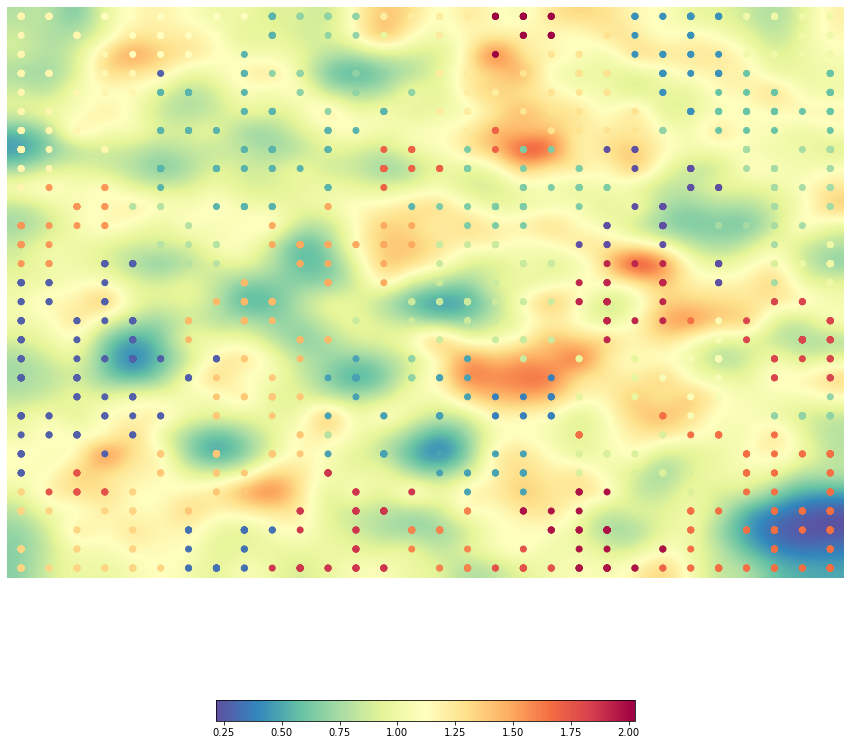

In [ ]:
som_testing(som_30,unique_bmus_30, 35)

##### k = 40

-------------------------------------------------------------- k = 40  --------------------------------------------------------------


Som Clusters
[[32 32 32 32  7 21 21 21 21 21 21 31 31 31 36 36 36  5  5  5  5 25 22 22 22 22 22 16 16 16]
 [32 32 32 32  7 21 21 21 21 21 21 31 31 31 36 36 36  5  5  5  5 25 22 22 22 22 16 16 16 16]
 [32 32 32  7  7  7 21 21 21 21 31 31 31 31 31 17 36 36  5  5 25 25 22 22 22 22 16 16 16 16]
 [32 32 32  7  7  7  7 21 18 31 31 31 31 31 31 17 17 36 25 25 25 25 22 22 22 22 16 16 16 16]
 [11 32  7  7  7  7  7  7 18 18 31 31 31 31 17 17 17 17 25 25 25 25 25 22 22 22 16 16 16 16]
 [11 11 11  7  7 18 18 18 18 18 18 31 18 17 17 17 17 17 25 25 25 25 25 25 22 20 20 20 16 16]
 [11 11 11 11 18 18 18 18 18 18 18 18 18 18 30 17 17 30 30 25 25 25 25 25 25 20 20 20 20 20]
 [11 11 11 11 11 18 18 18 18 18 18 18 18 30 30 30 30 30 38 38 25  0  0  0  0 20 20 20 20 20]
 [11 11 11 11 18 18 18 18 18 18 18 18 30 30 30 30 30 30 38 38 38  0  0  0  0  0 20 20 20 20]
 [11 14 14 14 

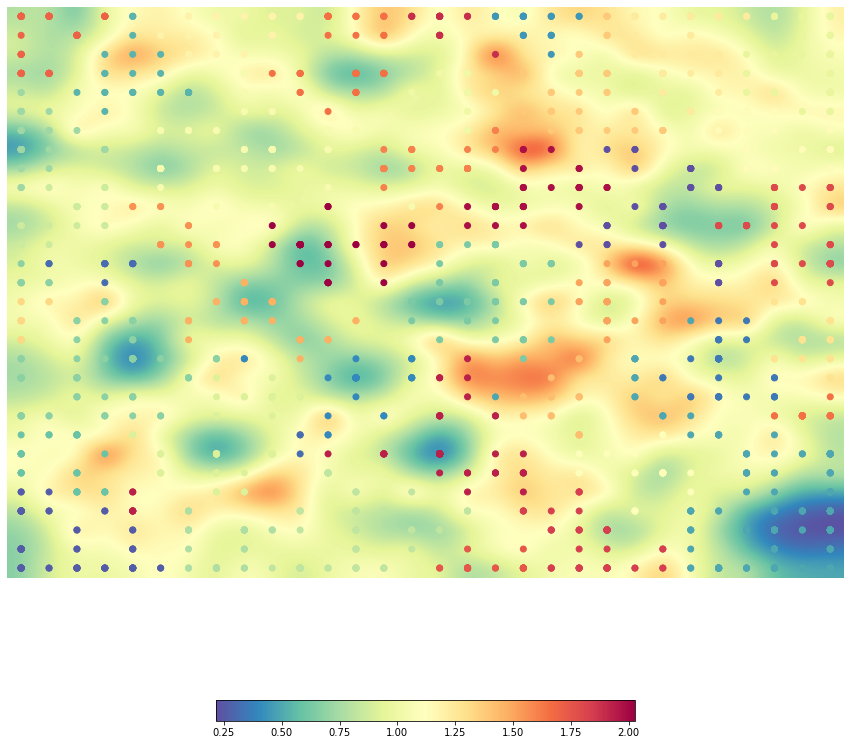

In [ ]:
som_testing(som_30,unique_bmus_30, 40)

k = 30 vs k = 40. Το 40 καλύτερο, πιο balaned ειδικά ως προς drama kai comedy

### 7.1 Συμπεράσματα testing 

Μετά απο τις δοκιμές με τις διάφορες παραμέτρους καταλήξαμε οτι οι πιο καλοί συνδιασμοί είναι για map 20x20 με k = 25 καθώς και για map 30x30 με k = 40. Οι επιλογές αυτές ήταν πολύ κοντά σε ποιότητα οπότε θα δοκιμαστούν και οι δύο στο πλήρες set και θα κρατήσουμε αυτήν που θα δώσει καλύτερα αποτελέσματα. 

Από τις δοκιμές είδαμε οτι σε πολλές περιπτώσεις οι κατηγορίες επαναλαμβάνονταν ή δεν είχανε πολλές συνδέσεις καθώς επίσης και οτι όσο ανέβαινε το μέγεθος του grid ήθελε να ανέβει και το k για να δώσει καλή εικόνα.

### 8. Ανάλυση τελικού dataset

Εφαρμόζουμε όλα τα βήματα που κάναμε παραπάνω για το training dataset στο τελικό dataset.

#### 8.1) Προετοιμασία

##### Δημιουργία SOM

In [ ]:
# φόρτωση FINAL SET
final_set_opt = joblib.load('/content/drive/MyDrive/neural/lab2/soms/final_set_opt.pkl')

In [ ]:
rows = 20
cols = 20
som1 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som1.train(final_set_opt, epochs=100)

CPU times: user 30min 8s, sys: 6.04 s, total: 30min 14s
Wall time: 15min 36s


In [ ]:
joblib.dump(som1, 'som1.pkl') 

['som1.pkl']

In [48]:
rows = 30
cols = 30
som2 = somoclu.Somoclu(cols, rows, compactsupport=False)
%time som2.train(final_set_opt, epochs=100)

CPU times: user 1h 1min 31s, sys: 12.5 s, total: 1h 1min 44s
Wall time: 32min 50s


In [49]:
joblib.dump(som2, 'som2.pkl') 

['som2.pkl']

##### Best Matching Units

In [46]:
# skip if calc
som1 = joblib.load('/content/drive/MyDrive/neural/lab2/soms/som1.pkl')  

In [ ]:
# skip if calc
som2 = joblib.load('/content/drive/MyDrive/neural/lab2/soms/som2.pkl')  

In [52]:
bmus1 = som1.bmus
print(bmus1.shape)

(5000, 2)


In [53]:
bmus2 = som2.bmus
print(bmus2.shape)

(5000, 2)


In [54]:
unique_bmus1, indices = np.unique(bmus1, return_inverse=True, axis=0)
print(unique_bmus1.shape)

(330, 2)


In [55]:
unique_bmus2, indices = np.unique(bmus2, return_inverse=True, axis=0)
print(unique_bmus2.shape)

(669, 2)


#### 8.2) Ανάλυση

##### Clustering

###### SOM 1

In [56]:
som1.cluster(KMeans(n_clusters = 25))
print(som1.clusters)

[[ 9  9  9  1  1  1  1  1  5  5 13 13 13 10 10 10 10 11 11 11]
 [ 9  9  9  1  1  1  1  1  5  5 13 13 13 10 10 10 10 10 11 11]
 [ 9  9  9 19  1  1  1  5  5  5 13 13 13 21 10 10 10 10 11 11]
 [12 12 19 19 19 19  5  5  5 13 13 13 13 21 21 10 11 11 11 11]
 [12 12 12 19 19 19 17 17 13 13 13 13 21 21 11 11 11 11 11 11]
 [12 12 12  9 19 17 17 17 17 21 21 21 21 21 21 11 11 11 11 11]
 [12 12 12 15 15 17 17 17 17 21 21 21 21 21 24 11 11 11 11 11]
 [16 16 15 15 15 15 17 17 17 21 21  6  6 21 24 24 11 11 11 11]
 [16 16 16 15 15 15  9  9  9  3 21  6  6 24 24 24 11 11 11 11]
 [16 16 16 16 16  9  9  9  8  8  8  8  8 24 24 24 11 11 11 11]
 [ 0  0  0 16  3  3  8  8  8  8  8  8  8  3  3  3  3  3  6  6]
 [ 0  0  0  3  3 18 18  8  8  8  8  8  8  3  3  3  3  3  6  6]
 [ 0  0  0 18 18 18 18 18  8  8  8  8  8  3  3  3  3  3  6  6]
 [ 0  0  3 18 18 18 18 18  4  4  4  4  4  3  3  3  3  3  3  3]
 [11  2  2  2  2 18 18 18  4  4  4  4  4  3  3  3  3  3  3  3]
 [ 2  2  2  2  2 18 18  4  4  4  4 14 14 14 14  3  3  3

In [57]:
som2.cluster(KMeans(n_clusters=40))
print(som2.clusters)

[[23 23 23 23 23 23 23 23 23 23 23 23 23  4  4  4  4  4  4 26 26 26 35 35 35 28 28 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 23 23  4  4  4  4  4 26 26 26 26 35 35 35 28 28 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 23 11 39  4  4  4  4 26 26 26 26 35 35 35 28 28 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 11 11 11  4  4  4 26 26 26 18 26  7 35 35 36 36 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 11 11 11 11 39 26 26 26 18 18 18  7  7  7 36 36 36 36 36]
 [23 23 23 23 23 23 23 23 23 23  9 11 11 11 39 39 39 39 18 18 18  7  7  7  7  7 36 36 36 36]
 [19 19 23  0  0  0  0  0  0  9  9  9 39 39 39 39 39 39 18 18 18 18  7  7  7  7  7 36 36 36]
 [19 19 19  0  0  0  0  0  0  9  9  9 39 39 39 39 39 39 18 18 18 18 18 27  7  7 30 36 12 12]
 [19 19 19  0  0  0  0  0  0  9  9  9 39 39 39 39 39 39 18 18 18 18 27 27 27 12 12 12 12 12]
 [19 19 19  0  0  0  0  0  0  9  9  9  9 17 17 17  1  1  1  1  1 27 27 27 27 12 12 12 12 12]
 [ 4 19 31 31 31 31  0  0 13 13  9  9 32 17 17 17  1  1  1  1  1  1 27

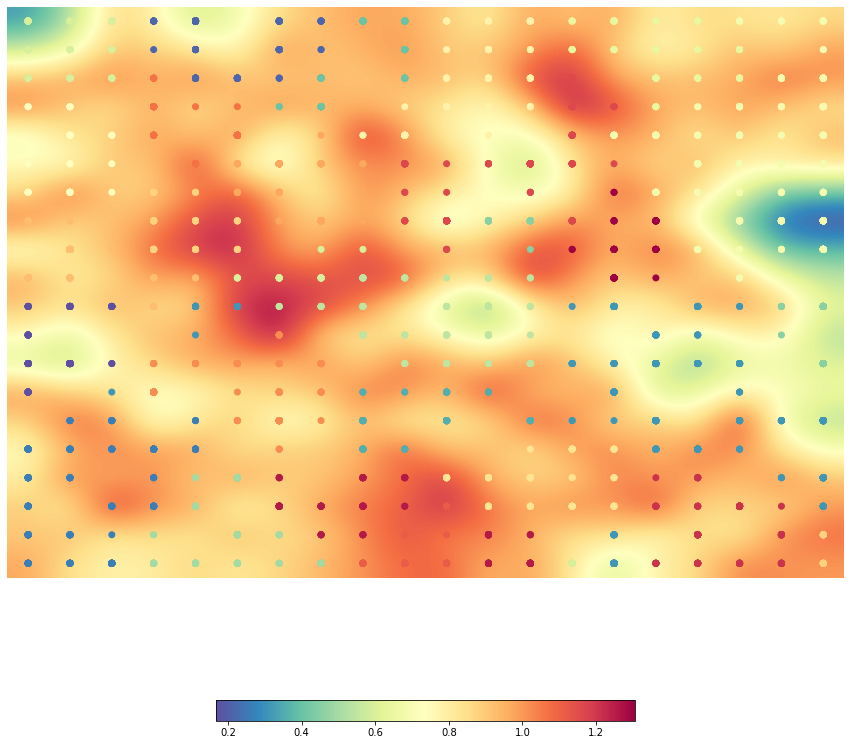

In [62]:
som1.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()

In [60]:
unique_values, counts = np.unique(som1.clusters, return_counts=True)
arr = np.asarray((unique_values, counts))
sorted_arr = arr[ :, arr[1].argsort()]
print("\033[1m Clusters sorted by increasing number of neurons for S1: \033[0m")
print("Cluster index")
print("Number of neurons")
print(sorted_arr)

 Clusters sorted by increasing number of neurons for S1: 
Cluster index
Number of neurons
[[20 24 19  5  6 16 15  0 12  7 17  1 10 23 14  4 22  9 13 18 21  8  2 11  3]
 [ 6  9  9 10 10 11 11 11 11 13 13 13 14 14 14 14 15 17 17 17 20 23 23 40 45]]


In [68]:
for i in range(25):
        print("---------------------------------------------------------------------------------\033[1m Cluster {} \033[0m---------------------------------------------------------------------------------".format(i))
        print()
        cluster_coordinates = print_cluster_neurons_movies_report(som1,unique_bmus1,i)
        cluster_movies_ids = neuron_movies_report(som1,cluster_coordinates)
        _ = print_categories_stats(cluster_movies_ids)
        print()

--------------------------------------------------------------------------------- Cluster 0 ---------------------------------------------------------------------------------

Overall Cluster Genres stats:
[('"Short Film"', 189), ('"Animation"', 43), ('"Drama"', 22), ('"Documentary"', 19), ('"Comedy film"', 16), ('"Silent film"', 7), ('"Science Fiction"', 7), ('"Family Film"', 6), ('"Fantasy"', 5), ('"Musical"', 5), ('"Computer Animation"', 5), ('"Indie"', 5), ('"Animated cartoon"', 4), ('"Children\'s"', 4), ('"Anime"', 3), ('"Action"', 3), ('"Romance Film"', 3), ('"Experimental film"', 2), ('"Biographical film"', 2), ('"Propaganda film"', 2), ('"Educational"', 2), ('"Western"', 2), ('"Japanese Movies"', 2), ('"Gender Issues"', 1), ('"Sponsored film"', 1), ('"Adventure"', 1), ('"Teen"', 1), ('"Surrealism"', 1), ('"Stop motion"', 1), ('"Avant-garde"', 1), ('"Language & Literature"', 1), ('"Black-and-white"', 1), ('"Sports"', 1), ('"Children\'s/Family"', 1), ('"Coming of age"', 1), ('"War

###### SOM 2

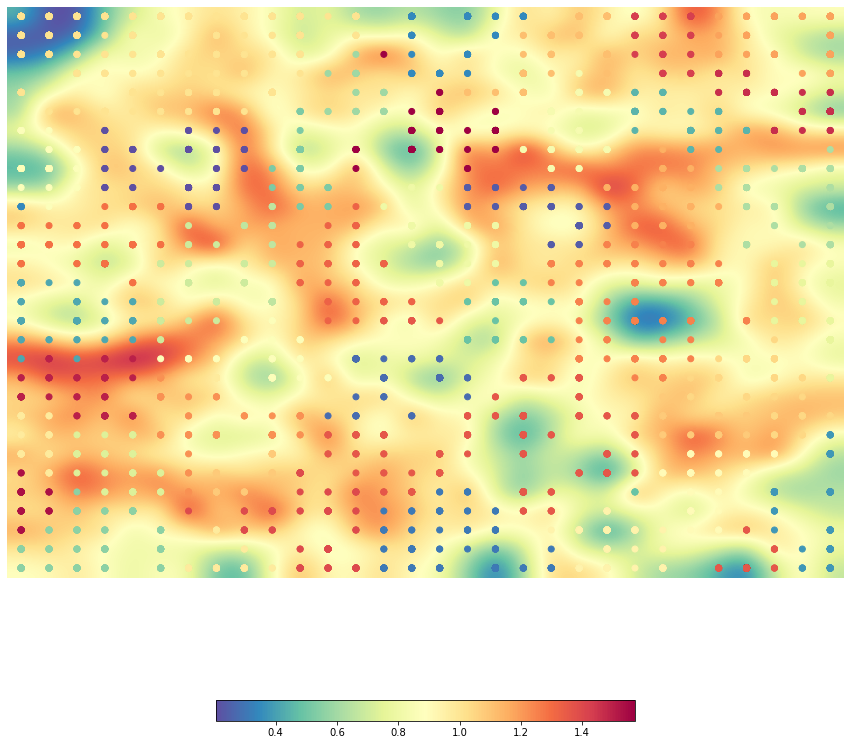

In [67]:
som2.view_umatrix(bestmatches=True, colorbar=True, figsize=(15, 15)); matplotlib.pyplot.show()

In [61]:
unique_values, counts = np.unique(som2.clusters, return_counts=True)
arr = np.asarray((unique_values, counts))
sorted_arr = arr[ :, arr[1].argsort()]
print("\033[1m Clusters sorted by increasing number of neurons for S2: \033[0m")
print("Cluster index")
print("Number of neurons")
print(sorted_arr)

 Clusters sorted by increasing number of neurons for S2: 
Cluster index
Number of neurons
[[38 11 35 13 15 36 16 37  7  9 27  1 22 20 26 21 28  8  4 25 29 18  6 14  5 24  2 32 31 34 10 12 17 39  0  3 19 30 23 33]
 [ 6 11 11 12 14 15 16 16 16 16 16 17 17 17 18 18 18 18 19 19 20 20 20 20 21 21 21 21 23 23 23 24 24 24 26 27 32 52 71 77]]


In [69]:
for i in range(40):
        print("---------------------------------------------------------------------------------\033[1m Cluster {} \033[0m---------------------------------------------------------------------------------".format(i))
        print()
        cluster_coordinates = print_cluster_neurons_movies_report(som2,unique_bmus2,i)
        cluster_movies_ids = neuron_movies_report(som2,cluster_coordinates)
        _ = print_categories_stats(cluster_movies_ids)
        print()

--------------------------------------------------------------------------------- Cluster 0 ---------------------------------------------------------------------------------

Overall Cluster Genres stats:
[('"Drama"', 104), ('"Black-and-white"', 102), ('"Silent film"', 32), ('"Indie"', 21), ('"Romance Film"', 18), ('"Melodrama"', 14), ('"War film"', 12), ('"Pre-Code"', 9), ('"World cinema"', 5), ('"Adventure"', 5), ('"Western"', 4), ('"Film noir"', 4), ('"Action"', 4), ('"Film adaptation"', 3), ('"Political drama"', 3), ('"Japanese Movies"', 3), ('"Biographical film"', 2), ('"Biography"', 2), ('"Biopic [feature]"', 2), ('"Comedy-drama"', 2), ('"Costume drama"', 2), ('"Docudrama"', 2), ('"Family Film"', 2), ('"Fantasy"', 2), ('"Epic"', 2), ('"Romantic drama"', 2), ('"Horror"', 2), ('"Period piece"', 2), ('"Mystery"', 2), ('"Musical"', 2), ('"Film u00e0 clef"', 1), ('"Tragedy"', 1), ('"Anti-war film"', 1), ('"Anti-war"', 1), ('"Art film"', 1), ('"Thriller"', 1), ('"Chinese Movies"', 1), 

Παρατηρούμε οτι το som2 έχει καλύτερα clusters, τα οποία είναι πιο balanced και με μεγαλύτερη ποικιλία.

### 9. Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering έχουμε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής μας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. 
(Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.)

Για τον τελικό χάρτη SOM που θα παράξαμε για τη συλλογή μας, αναλύουμε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM:

**Να σημειωθεί πως βέλτιστο som θεωρούμε το som2, το οποίο ειναι 30x30 με k = 40. Ωστώσο για τις ανάγκες των απαντήσεων χρησιμοποιούμε και τον μικρότερο χάρτη som1 που ειναι 20x20**

#### 9.1) Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.

Για να απαντήσουμε στο ερώτημα, θα τυπώσουμε μια λίστα που θα περιέχει ζευγάρια με τις καρηγορίες των ταινιών και τον αριθμό των νευρώνων στους οποίους εμφανίζεται η κάθε κατηγορία. Θα αντιπαραβάλλουμε τα ευρήματα που θα πάρουμε από αυτήν την λίστα με τις περισσότερο και λιγότερο συχνές κατηγορίες των ταινιών μας που είδαμε νωρίτερα.

In [139]:
categories_stats = print_categories_stats([i for i in range(5000)])
most_frequent_categories = categories_stats[0:5]
least_frequent_categories = categories_stats[-10:]
print()
print("--------------------------------------------------------------------------------- \033[1m 5 most frequent categories \033[0m ---------------------------------------------------------------------------------")
for cat in most_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(cat[0],cat[1]))
print("--------------------------------------------------------------------------------- \033[1m 10 least frequent categories \033[0m ---------------------------------------------------------------------------------")
for cat in least_frequent_categories:
    print("\033[1mCategory:\033[0m {} \033[1mCounts: \033[0m{}".format(cat[0],cat[1]))
print("---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


---------------------------------------------------------------------------------  5 most frequent categories  ---------------------------------------------------------------------------------
Category: "Drama" Counts: 2323
Category: "Comedy" Counts: 1185
Category: "Thriller" Counts: 819
Category: "Romance Film" Counts: 817
Category: "Action" Counts: 729
---------------------------------------------------------------------------------  10 least frequent categories  ---------------------------------------------------------------------------------
Category: "Business" Counts: 1
Category: "Buddy cop" Counts: 1
Category: "Language & Literature" Counts: 1
Category: "British Empire Film" Counts: 1
Category: "Exploitation" Counts: 1
Category: "Prison film" Counts: 1
Category: "Sponsored film" Counts: 1
Category: "Jukebox musical" Counts: 1
Category: "Supermarionation" Counts: 1
Category: "Family & Personal Relationships" Counts: 1
-------------------------------------------------------------

In [71]:
def print_categories_stats(IDs):
    total_categories = []
    for movie_id in IDs:
        movie_categories = categories[movie_id][0].split(",")  
        for i in range(len(movie_categories)):
            total_categories.extend([movie_categories[i].strip()])
    unique_categories, counts = np.unique(total_categories, return_counts=True)
    largest_categories_indexes = np.argsort(counts)[::-1]
    result = [(unique_categories[index],counts[index]) for index in largest_categories_indexes]
    #print("Overall Cluster Genres stats:") 
    #print(result)
    return result

In [72]:
def number_of_neurons_in_category(category):
    cnt = 0                                                                     # Αρχικοποιούμε τον μετρητή με τους διαφορετικούς νευρώνες στους οποίους απεικονίζεται μία κατηγορίας
    for (cat,_) in neurons_categories_stats:                                    # Διατρέχουμε την λίστα neurons_categories_stats
        if cat==category:                                                       # και αν συναντήσουμε την κατηγορία που εξετάζουμε
           cnt+=1                                                               # αυξάνουμε τον μετρητή κατά ένα
    return cnt                                                                  # Επιστρέφουμε τον μετρητή

In [142]:
neurons_categories_stats = []                                                   # Αρχικοποιούμε μία λίστα με την στατιστική των κατηγοριών των ταινιών για όλους τους νευρώνες του πλέγματος
for i in range(20):  
    for j in range(20):                                                         # Για κάθε νευρώνα στο 20 x 20 grid
          neuron_IDs_list = neuron_movies_report(som1,[[i,j]])                   # βρίσκουμε τα IDs των ταινιών
          neuron_categories_stats = print_categories_stats(neuron_IDs_list)     # τη στατιστική των κατηγοριών τους
          neurons_categories_stats.extend(neuron_categories_stats)              # και την κάνουμε append στη συνολική λίστα

total_categories = []                                                           # Αρχικοποιούμε τη λίστα με όλες τις κατηγορίες του dataset μας
for i in range(categories.shape[0]):                                            # Για όλες τις ταινίες (σύνολο 5000)
    cat = [category.strip() for category in categories[i][0].split(",")]        # βρίσκουμε την λίστα με τις κατηγορίες τους
    total_categories.extend(cat)                                                # και την κάνουμε extend στη συνολική λίστα
unique_categories = np.unique(total_categories)                                 # Βρίσκουμε τις μοναδικές κατηγορίες (σύνολο 271) του dataset μας

final = []
for category in unique_categories:                                              # Για κάθε μοναδική κατηγορία
    final.append((category,number_of_neurons_in_category(category)))            # βρίσκουμε τον αριθμό των νευρώνων στους οποίους απεικονίζεται και το κάνουμε append στη λίστα final
final_sorted = sorted(final, key=lambda x: x[1])                                # Ταξινομούμε τη λίστα σε αύξουσα σειρά αριθμού νευρώνων

final = np.asarray(final_sorted)                                                # Μετατρέπουμε την ταξινομημένη λίστα σε πίνακα
refinal = final[::-1]
print("SOM 1")
print(refinal[0:5])                                                            # Τυπώνουμε τον πίνακα

SOM 1
[['"Drama"' '173']
 ['"Comedy"' '123']
 ['"Adventure"' '112']
 ['"Indie"' '107']
 ['"Romance Film"' '104']]


Παρατηρώ οτι για το som1, 4 από τις 5 κατηγορίες με τους περισσότερους νευρώνες ανήκουν στις 5 πιο πολυπληθείς κατηγορίες των ταινιών του database μας.

In [143]:
neurons_categories_stats = []                                                   # Αρχικοποιούμε μία λίστα με την στατιστική των κατηγοριών των ταινιών για όλους τους νευρώνες του πλέγματος
for i in range(20):  
    for j in range(20):                                                         # Για κάθε νευρώνα στο 20 x 20 grid
          neuron_IDs_list = neuron_movies_report(som2,[[i,j]])                   # βρίσκουμε τα IDs των ταινιών
          neuron_categories_stats = print_categories_stats(neuron_IDs_list)     # τη στατιστική των κατηγοριών τους
          neurons_categories_stats.extend(neuron_categories_stats)              # και την κάνουμε append στη συνολική λίστα

total_categories = []                                                           # Αρχικοποιούμε τη λίστα με όλες τις κατηγορίες του dataset μας
for i in range(categories.shape[0]):                                            # Για όλες τις ταινίες (σύνολο 5000)
    cat = [category.strip() for category in categories[i][0].split(",")]        # βρίσκουμε την λίστα με τις κατηγορίες τους
    total_categories.extend(cat)                                                # και την κάνουμε extend στη συνολική λίστα
unique_categories = np.unique(total_categories)                                 # Βρίσκουμε τις μοναδικές κατηγορίες (σύνολο 271) του dataset μας

final = []
for category in unique_categories:                                              # Για κάθε μοναδική κατηγορία
    final.append((category,number_of_neurons_in_category(category)))            # βρίσκουμε τον αριθμό των νευρώνων στους οποίους απεικονίζεται και το κάνουμε append στη λίστα final
final_sorted = sorted(final, key=lambda x: x[1])                                # Ταξινομούμε τη λίστα σε αύξουσα σειρά αριθμού νευρώνων

final = np.asarray(final_sorted)                                                # Μετατρέπουμε την ταξινομημένη λίστα σε πίνακα
refinal = final[::-1]
print("SOM 2")
print(refinal[0:5])                                                             # Τυπώνουμε τον πίνακα

SOM 2
[['"Drama"' '249']
 ['"Romance Film"' '108']
 ['"World cinema"' '84']
 ['"Comedy"' '82']
 ['"Indie"' '64']]


Αντίστοιχα και για το som2, 3 από τις 5 κατηγορίες με τους περισσότερους νευρώνες είναι και οι πιο πολυπληθείς κατηγορίες του database μας.

#### 9.2) Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.

Για να απαντήσουμε σε αυτό το ερώτημα εμφανίζουμε ξανά τον πίνακα με τα clusters και με βάση αυτόν δίνουμε μερικά χαρακτηριστικά παραδείγματα. 
Θα χρησιμοποιήσουμε το μικρότερο som1(20x20).

In [79]:
print(som1.clusters)

[[ 9  9  9  1  1  1  1  1  5  5 13 13 13 10 10 10 10 11 11 11]
 [ 9  9  9  1  1  1  1  1  5  5 13 13 13 10 10 10 10 10 11 11]
 [ 9  9  9 19  1  1  1  5  5  5 13 13 13 21 10 10 10 10 11 11]
 [12 12 19 19 19 19  5  5  5 13 13 13 13 21 21 10 11 11 11 11]
 [12 12 12 19 19 19 17 17 13 13 13 13 21 21 11 11 11 11 11 11]
 [12 12 12  9 19 17 17 17 17 21 21 21 21 21 21 11 11 11 11 11]
 [12 12 12 15 15 17 17 17 17 21 21 21 21 21 24 11 11 11 11 11]
 [16 16 15 15 15 15 17 17 17 21 21  6  6 21 24 24 11 11 11 11]
 [16 16 16 15 15 15  9  9  9  3 21  6  6 24 24 24 11 11 11 11]
 [16 16 16 16 16  9  9  9  8  8  8  8  8 24 24 24 11 11 11 11]
 [ 0  0  0 16  3  3  8  8  8  8  8  8  8  3  3  3  3  3  6  6]
 [ 0  0  0  3  3 18 18  8  8  8  8  8  8  3  3  3  3  3  6  6]
 [ 0  0  0 18 18 18 18 18  8  8  8  8  8  3  3  3  3  3  6  6]
 [ 0  0  3 18 18 18 18 18  4  4  4  4  4  3  3  3  3  3  3  3]
 [11  2  2  2  2 18 18 18  4  4  4  4  4  3  3  3  3  3  3  3]
 [ 2  2  2  2  2 18 18  4  4  4  4 14 14 14 14  3  3  3

In [146]:
cluster = 2
cluster_coordinates = print_cluster_neurons_movies_report(som1,unique_bmus1,cluster)
cluster_movies_ids = neuron_movies_report(som1,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Thriller"', 293), ('"Drama"', 224), ('"Crime Fiction"', 139), ('"Crime Thriller"', 120), ('"Mystery"', 112), ('"Psychological thriller"', 77), ('"World cinema"', 52), ('"Suspense"', 46), ('"Film noir"', 41), ('"Black-and-white"', 40), ('"Indie"', 26), ('"Film adaptation"', 19), ('"Romance Film"', 18), ('"Science Fiction"', 16), ('"Action"', 15), ('"Comedy"', 12), ('"Crime Drama"', 12), ('"Horror"', 12), ('"Detective"', 11), ('"Erotic thriller"', 11), ('"Detective fiction"', 11), ('"Adventure"', 9), ('"Period piece"', 9), ('"Courtroom Drama"', 8), ('"Political drama"', 7), ('"Japanese Movies"', 7), ('"Gangster Film"', 7), ('"Television movie"', 7), ('"Melodrama"', 6), ('"Supernatural"', 6), ('"Spy"', 6), ('"Fantasy"', 6), ('"Heist"', 6), ('"Ensemble Film"', 5), ('"Black comedy"', 5), ('"Romantic drama"', 5), ('"Political thriller"', 5), ('"Art film"', 4), ('"Psycho-biddy"', 4), ('"Comedy Thriller"', 4), ('"Caper story"', 3), ('"Coming of age"', 3), ('"M

In [147]:
cluster = 6
cluster_coordinates = print_cluster_neurons_movies_report(som1,unique_bmus1,cluster)
cluster_movies_ids = neuron_movies_report(som1,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Comedy film"', 147), ('"Drama"', 62), ('"Romance Film"', 38), ('"Family Film"', 5), ('"Musical"', 5), ('"Action"', 4), ('"Comedy-drama"', 3), ('"Satire"', 3), ('"Fantasy"', 3), ('"Adventure"', 3), ('"Crime Fiction"', 2), ('"Domestic Comedy"', 2), ('"Romantic comedy"', 2), ('"Black comedy"', 2), ('"War film"', 2), ('"Short Film"', 2), ('"Historical fiction"', 1), ('"Christmas movie"', 1), ('"Children\'s/Family"', 1), ('"Ensemble Film"', 1), ('"World cinema"', 1), ('"Holiday Film"', 1), ('"Horror"', 1), ('"Indie"', 1), ('"Western"', 1), ('"Romantic drama"', 1), ('"Science Fiction"', 1), ('"Silent film"', 1), ('"Slice of life story"', 1), ('"Sports"', 1), ('"Stand-up comedy"', 1), ('"Teen"', 1), ('"Thriller"', 1), ('"Tragicomedy"', 1), ('"Music"', 1)]


Βλέπουμε για παράδειγμα το cluster 2 που έχει ως επι το πλέιστον, Thrillers, Drama, Crime Fiction και Crime Thriller κατηγορίες και βρίσκεται κάτω αριστερά να απέχει από το cluster 6 που βρίσκεται στην μέση και δεξιά και αποτελείται απο comedy films, romance films, family filds, dramas και musicals. Οι κατηγρίες αυτές απέχουν πολύ και νοηματικά αλλά και χωροταξικά.

#### 9.3) Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Όπως και πριν εμφανίζουμε τον πίνακα με τα clusters και παίρνουμε συγκεκριμένα παραδείγματα. Αυτήν την φορά από το som2 που είναι και 30x30

In [148]:
print(som2.clusters)

[[23 23 23 23 23 23 23 23 23 23 23 23 23  4  4  4  4  4  4 26 26 26 35 35 35 28 28 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 23 23  4  4  4  4  4 26 26 26 26 35 35 35 28 28 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 23 11 39  4  4  4  4 26 26 26 26 35 35 35 28 28 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 11 11 11  4  4  4 26 26 26 18 26  7 35 35 36 36 28 28 28]
 [23 23 23 23 23 23 23 23 23 23 23 11 11 11 11 39 26 26 26 18 18 18  7  7  7 36 36 36 36 36]
 [23 23 23 23 23 23 23 23 23 23  9 11 11 11 39 39 39 39 18 18 18  7  7  7  7  7 36 36 36 36]
 [19 19 23  0  0  0  0  0  0  9  9  9 39 39 39 39 39 39 18 18 18 18  7  7  7  7  7 36 36 36]
 [19 19 19  0  0  0  0  0  0  9  9  9 39 39 39 39 39 39 18 18 18 18 18 27  7  7 30 36 12 12]
 [19 19 19  0  0  0  0  0  0  9  9  9 39 39 39 39 39 39 18 18 18 18 27 27 27 12 12 12 12 12]
 [19 19 19  0  0  0  0  0  0  9  9  9  9 17 17 17  1  1  1  1  1 27 27 27 27 12 12 12 12 12]
 [ 4 19 31 31 31 31  0  0 13 13  9  9 32 17 17 17  1  1  1  1  1  1 27

In [149]:
cluster = 30
cluster_coordinates = print_cluster_neurons_movies_report(som2,unique_bmus2,cluster)
cluster_movies_ids = neuron_movies_report(som2,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Comedy"', 245), ('"Horror"', 23), ('"Teen"', 19), ('"Black comedy"', 18), ('"Slapstick"', 18), ('"World cinema"', 14), ('"Sports"', 13), ('"Crime Fiction"', 12), ('"Horror Comedy"', 11), ('"Action"', 11), ('"Short Film"', 7), ('"Fantasy"', 7), ('"Sex comedy"', 7), ('"Science Fiction"', 6), ('"Gross-out film"', 5), ('"Gross out"', 5), ('"Cult"', 5), ('"Satire"', 5), ('"Buddy film"', 5), ('"Screwball comedy"', 5), ('"Chinese Movies"', 5), ('"Adventure"', 5), ('"Filipino Movies"', 5), ('"Indie"', 4), ('"Crime Comedy"', 4), ('"Comedy-drama"', 4), ('"Comedy of Errors"', 4), ('"Comedy film"', 4), ('"Zombie Film"', 4), ('"Absurdism"', 3), ('"Mockumentary"', 3), ('"Western"', 3), ('"B-movie"', 3), ('"Stoner film"', 3), ('"Mystery"', 3), ('"Comedy of manners"', 3), ('"Coming of age"', 3), ('"Ensemble Film"', 2), ('"Animation"', 2), ('"Children\'s/Family"', 2), ('"Japanese Movies"', 2), ('"Creature Film"', 2), ('"Detective fiction"', 2), ('"Detective"', 2), ('"D

In [151]:
cluster = 16
cluster_coordinates = print_cluster_neurons_movies_report(som2,unique_bmus2,cluster)
cluster_movies_ids = neuron_movies_report(som2,cluster_coordinates)
cluster_category_stats = print_categories_stats(cluster_movies_ids)
print("Overall Cluster Genres stats:") 
print(cluster_category_stats)

Overall Cluster Genres stats:
[('"Comedy"', 112), ('"Black-and-white"', 111), ('"Short Film"', 63), ('"Slapstick"', 23), ('"Silent film"', 19), ('"Family Film"', 15), ('"Indie"', 12), ('"Romance Film"', 10), ('"Musical"', 7), ('"Crime Fiction"', 5), ('"Satire"', 5), ('"Romantic comedy"', 4), ('"Mystery"', 3), ('"Fantasy"', 3), ('"Crime Comedy"', 3), ('"World cinema"', 3), ('"Children\'s/Family"', 2), ('"Comedy of Errors"', 2), ('"Comedy of manners"', 2), ('"War film"', 2), ('"Western"', 2), ('"Comedy-drama"', 2), ('"Caper story"', 1), ('"Detective fiction"', 1), ('"Animal Picture"', 1), ('"Adventure"', 1), ('"Adventure Comedy"', 1), ('"Foreign legion"', 1), ('"Detective"', 1), ('"Ensemble Film"', 1), ('"Fantasy Comedy"', 1), ('"Film noir"', 1), ('"Workplace Comedy"', 1), ('"Musical comedy"', 1), ('"Operetta"', 1), ('"Parody"', 1), ('"Romantic fantasy"', 1), ('"Screwball comedy"', 1), ('"Sex comedy"', 1), ('"Surrealism"', 1), ('"Whodunit"', 1), ('"Absurdism"', 1)]


Βλέπουμε χαρακτηριστικά τα clusters 16 & 30 που βρίσκονται στην δεξιά μεριά του χάρτη. Και τα δύο αποτελούνται κυρίως απο κωμωδίες με το πρώτο να είναι μηκρού μήκος και ασπρόμαυρες ενώ το δεύτερο horror, black και teen comedies

#### 9.4) Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.

Και πάλι, με βάση τον χάρτη παρατηρούμε τα εξής.

To cluster 33 ενώ ειναι το μεγαλύτερό μας έχει την κατηγορία short film comedy. Βρίσκεται κάτω δεξιά με το cluster 20 που είναι animation, family adventure kai είναι ένα απο τα μικρά clusters.

Ιδιαίτερο ενδιαφέρον έχει επίσης και το cluster 1 το οποίο είναι και ένα απο τα μικρότερα clusters μας και ανήκει στην κατηγορία comedy indie είναι κοντα με το 18 που είναι drama, thriller black & white.

#### 9.5) Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.

Ένα ενδιαφέρον έχει η κάτω αριστερά "action adventure" γωνιά η οποία έχει μικρά clusters τα οποία όλα όμως είναι action adventure με κάποια υποκατηγορία. Αυτά είναι τα clusters 38, 10, 15 και 22

Αντίστοιχα και το cluster 21 το οποίο έχει όλα τα χαρακτηριστικά ενός ντοκιματναίρ, όντας history & culture, indie, biography κλπ.